# Análise Preditiva Avançada

## Bibliotecas

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from time import strptime

from sklearn.externals import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Carregamento dos dados

In [2]:
SEED = 314

In [3]:
# df = pd.read_csv('https://raw.githubusercontent.com/lsnascimento/apa/master/input/Marketing.csv', sep=';')
df = pd.read_csv('../input/Marketing.csv', sep=';')
df2 = df.copy()

In [4]:
print('Rows: %s\nCols: %s\n' % df.shape)

df.head()

Rows: 41188
Cols: 19



,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1_1,93.994,-36_4,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1_1,93.994,-36_4,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1_1,93.994,-36_4,no
3,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1_1,93.994,-36_4,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1_1,93.994,-36_4,no


## Métodos

In [56]:
def save(obj, name):
    try:
        name = '%s_%s.gz' % (name, dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

        joblib.dump(obj, '../backup/{}'.format(name), compress=True)
        
        print('Objeto {!r} salvo com sucesso'.format(name))
    except:
        print('Erro ao tentar salvar o objeto')

In [27]:
def duration_classifier(x):
    classifier = ''
    
    if x <= 10:
        classifier = '[0 - 10]'
    elif x <= 20:
        classifier = '[11 - 20]'
    elif x <= 30:
        classifier = '[21 - 30]'
    elif x <= 40:
        classifier = '[31 - 40]'
    elif x <= 50:
        classifier = '[41 - 50]'
    elif x <= 60:
        classifier = '[51 - 60]'
    elif x <= 70:
        classifier = '[61 - 70]'
    elif x <= 80:
        classifier = '[71 - 80]'
    elif x <= 90:
        classifier = '[81 - 90]'
    elif x <= 100:
        classifier = '[91 - 100]'
    else:
        classifier = '[Maior que 100]'
        
    return classifier

In [38]:
def set_results(model, precision, recall, roc_auc, threshold):
    results.append(
        {
            'model': model, 
            'precision': precision, 
            'recall': recall, 
            'roc_auc': roc_auc,
            'threshold': threshold
        }
    )

In [39]:
def report(y_true, y_scores):
    print('Confusion Matrix:\n')
    print(confusion_matrix(y_true, y_scores))
    
    print('-' * 80)
    
    print('Classification Report:\n')
    print(classification_report(y_true, y_scores))

In [40]:
def set_threshold(y_scores, t, proba=False):
    if proba:
        calc = np.where(y_scores >= t, t, y_scores)
    else:
        calc = np.where(y_scores >= t, 1, 0)
    return calc

## Conhecimento dos dados

### Valores faltantes

In [7]:
df.isnull().sum()

AGE               0
JOB               0
MARITAL_STATUS    0
EDUCATION         0
DEFAULT           0
HOUSING           0
LOAN              0
CONTACT           0
MONTH             0
DAY_OF_WEEK       0
DURATION          0
CAMPAIGN          0
PDAYS             0
PREVIOUS          0
POUTCOME          0
EMP_VAR_RATE      0
CONS_PRICE_IDX    0
CONS_CONF_IDX     0
SUBSCRIBED        0
dtype: int64

**Análise:**
- Este dataset não possui nenhum valor faltante

### Variáveis numéricas

In [6]:
feat_num = df.select_dtypes(exclude=np.object)
feat_num.head()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
0,56,261,1,-1,0
1,57,149,1,-1,0
2,37,226,1,-1,0
3,40,151,1,-1,0
4,56,307,1,-1,0


In [7]:
feat_num.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,41188.0,40.024060,10.421250,17.0,32.0,38.0,47.0,98.0
DURATION,41188.0,258.285010,259.279249,0.0,102.0,180.0,319.0,4918.0
CAMPAIGN,41188.0,2.567593,2.770014,1.0,1.0,2.0,3.0,56.0
PDAYS,41188.0,-0.741988,1.510327,-1.0,-1.0,-1.0,-1.0,27.0
PREVIOUS,41188.0,0.172963,0.494901,0.0,0.0,0.0,0.0,7.0


**Análises:**
- Valores iguais à -1 no atributo **PDAYS** significa que não houve contato
- O atributo **DURATION** possui um valor de desvio padrão muito grande, acima do valor da média. Mais a frente será necessário uma normalização dos dados deste atributo para eles não terem um peso muito grande no momento da modelagem.
- O atributo **AGE** também possui um valor elevado, apesar da idade mínima ser 17 anos, a média da idade está em 40 anos.

### Variáveis categóricas

In [8]:
feat_cat = df.select_dtypes(include=np.object)
feat_cat.head()

,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,housemaid,married,basic_4y,no,no,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
1,services,married,high_school,unknown,no,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
2,services,married,high_school,no,yes,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
3,admin,married,basic_6y,no,no,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
4,services,married,high_school,no,no,yes,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no


In [9]:
est_descritiva = feat_cat.describe().T

est_descritiva['perc'] = (est_descritiva['freq'] / est_descritiva['count']) * 100

est_descritiva

,count,unique,top,freq,perc
JOB,41188,12,admin,10422,25.3035
MARITAL_STATUS,41188,4,married,24928,60.5225
EDUCATION,41188,8,university_degree,12168,29.5426
DEFAULT,41188,3,no,32588,79.1201
HOUSING,41188,3,yes,21576,52.3842
LOAN,41188,3,no,33950,82.4269
CONTACT,41188,2,cellular,26144,63.4748
MONTH,41188,10,may,13769,33.4296
DAY_OF_WEEK,41188,5,thu,8623,20.9357
POUTCOME,41188,3,nonexistent,35563,86.3431


**Análises:**
- 76% das pessoas não possuem contas em atraso. Isto pode indicar que as pessoas que não possuem contas em atraso tem um indício maior de aderir ao serviço.
- 82% das pessoas não possuem empréstimo pessoal.
- 86% das pessoas não possuem resultado da última campanha, isto pode ser um indicativo que o resultado da última campanha não tem um impacto significativo no resultado da campanha atual.
- Os atributos **CONS_PRICE_IDX** e **CONS_CONF_IDX** precisam ser convertidos para numéricos.
- 88% das pessoas não aderiu ao serviço. Isto está nos indicando que a nossa variável alvo está desbalanceada.

### JOB

In [10]:
df.groupby('JOB').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
JOB,,,,,
admin,38.187296,254.312128,2.623489,-0.679812,0.189023
blue-collar,39.555760,264.542360,2.558461,-0.899719,0.122542
entrepreneur,41.723214,263.267857,2.535714,-0.875687,0.138736
housemaid,45.500000,250.454717,2.639623,-0.741509,0.137736
management,42.362859,257.058140,2.476060,-0.759234,0.185021
retired,62.027326,273.712209,2.476744,-0.319767,0.327326
self-employed,39.949331,264.142153,2.660802,-0.859254,0.143561
services,37.926430,258.398085,2.587805,-0.877551,0.154951
student,25.894857,283.683429,2.104000,0.217143,0.524571


In [11]:
df.groupby('JOB').size()

JOB
admin            10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
dtype: int64

In [12]:
subscribed_by_jobs = df.groupby(['JOB', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_jobs['perc'] = (subscribed_by_jobs / df.shape[0]) * 100

subscribed_by_jobs

SUBSCRIBED       perc
JOB           SUBSCRIBED                       
admin         no                9070  22.020977
              yes               1352   3.282509
blue-collar   no                8616  20.918714
              yes                638   1.548995
entrepreneur  no                1332   3.233952
              yes                124   0.301059
housemaid     no                 954   2.316209
              yes                106   0.257357
management    no                2596   6.302807
              yes                328   0.796348
retired       no                1286   3.122269
              yes                434   1.053705
self-employed no                1272   3.088278
              yes                149   0.361756
services      no                3646   8.852093
              yes                323   0.784209
student       no                 600   1.456735
              yes                275   0.667670
technician    no                6013  14.598912
              yes                730   1.772361
unemployed    no                 870   2.112266
              yes                144   0.349616
unknown       no                 293   0.711372
              yes                 37   0.089832

**Análises:**
- Observando a tabela acima, pode-se concluir que no geral as profissões admin, technican e blue-collar possuem um percentual maior do que as outras profissões. Isto devido a sua maior quantidade de registros.

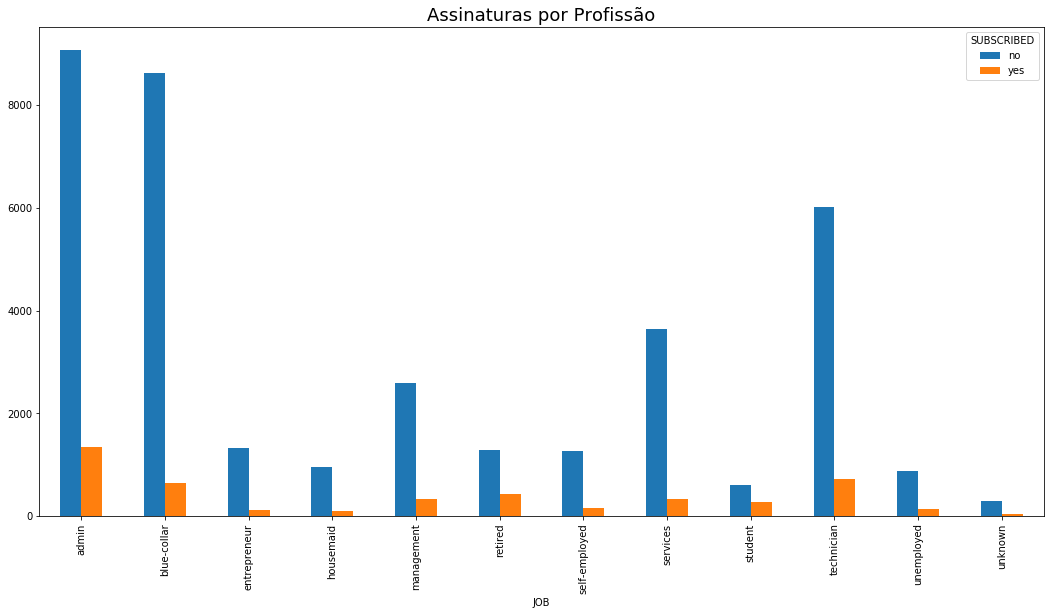

In [10]:
pd.crosstab(df['JOB'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Profissão', fontsize=18)

plt.show()

**Análises:** 
- Analisando as profissões individualmente, as profissões mais efetivas na adesão ao serviço são as student e retired correspondendo a um percentual de 31.43% e 25.23% respectivamente.

### MARITAL_STATUS

In [14]:
df.groupby('MARITAL_STATUS').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
MARITAL_STATUS,,,,,
divorced,44.899393,253.790330,2.61340,-0.787728,0.168690
married,42.307165,257.438623,2.57281,-0.780247,0.155608
single,33.158714,261.524378,2.53380,-0.643672,0.211359
unknown,40.275000,312.725000,3.18750,-0.400000,0.275000


In [15]:
subscribed_by_marital_status = df.groupby(['MARITAL_STATUS', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_marital_status['perc'] = (subscribed_by_marital_status / df.shape[0]) * 100

subscribed_by_marital_status

SUBSCRIBED       perc
MARITAL_STATUS SUBSCRIBED                       
divorced       no                4136  10.041760
               yes                476   1.155676
married        no               22396  54.375061
               yes               2532   6.147422
single         no                9948  24.152666
               yes               1620   3.933184
unknown        no                  68   0.165097
               yes                 12   0.029135

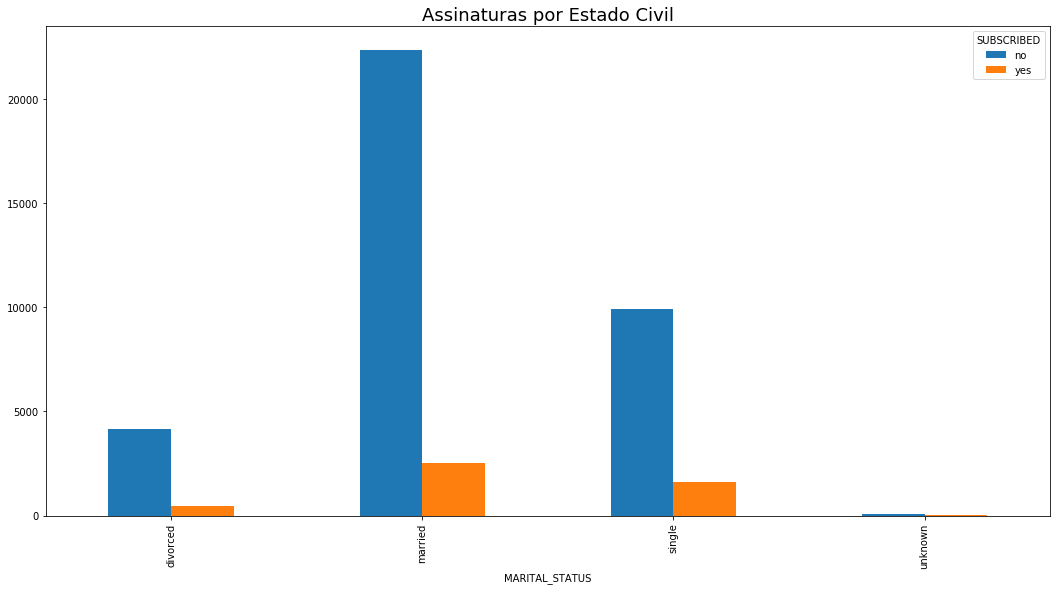

In [11]:
pd.crosstab(df['MARITAL_STATUS'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Estado Civil', fontsize=18)

plt.show()

**Análises:** 
- Analisando os estados civis da base podemos perceber que o mais efetivo na adesão ao serviço foram os solteiros com 14%, porém a classe que mais assinou o serviço foi a dos casados com 2532.

### EDUCATION

In [17]:
df.groupby('EDUCATION').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
EDUCATION,,,,,
basic_4y,47.596504,264.827826,2.600575,-0.770115,0.147031
basic_6y,40.448953,264.414485,2.556283,-0.870855,0.129145
basic_9y,39.061208,261.291811,2.532341,-0.850289,0.141439
high_school,37.998213,260.886810,2.568576,-0.749343,0.185917
illiterate,48.500000,276.777778,2.277778,-0.611111,0.111111
professional_course,40.080107,252.533855,2.586115,-0.706466,0.163075
university_degree,38.879191,253.223373,2.563527,-0.690664,0.192390
unknown,43.481225,262.390526,2.596187,-0.554593,0.226459


In [18]:
subscribed_by_education = df.groupby(['EDUCATION', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_education['perc'] = (subscribed_by_education / df.shape[0]) * 100

subscribed_by_education

SUBSCRIBED       perc
EDUCATION           SUBSCRIBED                       
basic_4y            no                3748   9.099738
                    yes                428   1.039138
basic_6y            no                2104   5.108284
                    yes                188   0.456444
basic_9y            no                5572  13.528212
                    yes                473   1.148393
high_school         no                8484  20.598232
                    yes               1031   2.503156
illiterate          no                  14   0.033990
                    yes                  4   0.009712
professional_course no                4648  11.284840
                    yes                595   1.444596
university_degree   no               10498  25.488006
                    yes               1670   4.054579
unknown             no                1480   3.593280
                    yes                251   0.609401

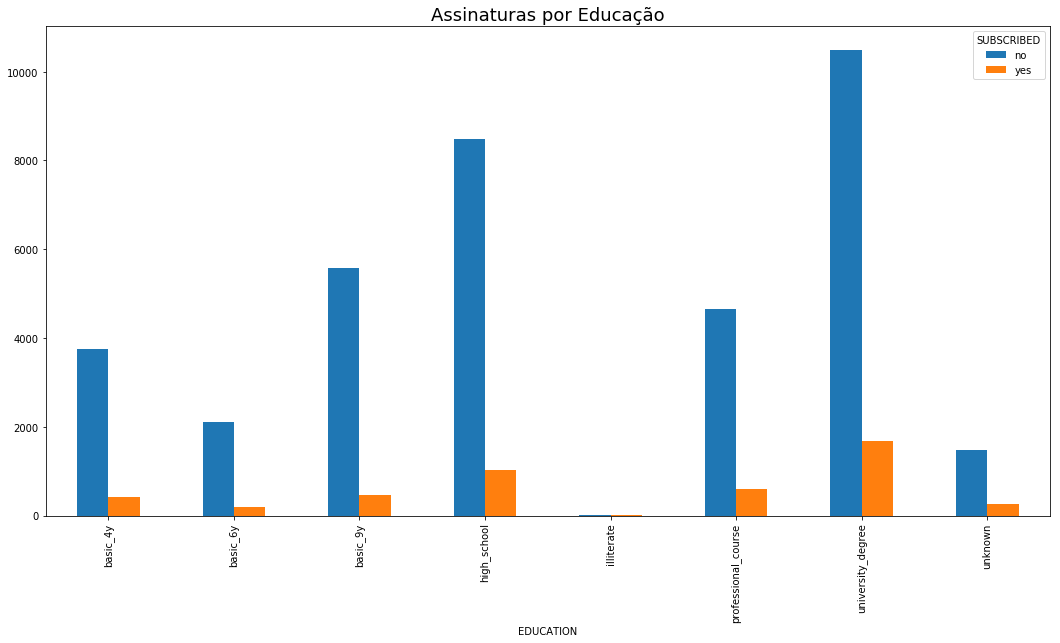

In [12]:
pd.crosstab(df['EDUCATION'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Educação', fontsize=18)

plt.show()

**Análises:** 
- Analisando os graus de estudo podemos perceber que o mais efetivo na adesão ao serviço foram os Analfabetos com 22%, porém a quantidade de membros dessa classe são escassos e podem ser tendenciosos, portanto é mais seguro afirmar que a classe que mais adere ao serviço é a de graduados na universidade em tanto em termos de porcentagem com 13,72% quanto em números absolutos com 1670 pessoas que assinaram o serviço.

### DEFAULT

In [20]:
df.groupby('DEFAULT').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
DEFAULT,,,,,
no,39.140635,259.842549,2.520744,-0.687278,0.199030
unknown,43.371990,252.435035,2.745609,-0.949285,0.074096
yes,42.333333,103.333333,1.333333,-1.000000,0.333333


In [21]:
subscribed_by_default = df.groupby(['DEFAULT', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_default['perc'] = (subscribed_by_default / df.shape[0]) * 100

subscribed_by_default

SUBSCRIBED       perc
DEFAULT SUBSCRIBED                       
no      no               28391  68.930271
        yes               4197  10.189861
unknown no                8154  19.797028
        yes                443   1.075556
yes     no                   3   0.007284

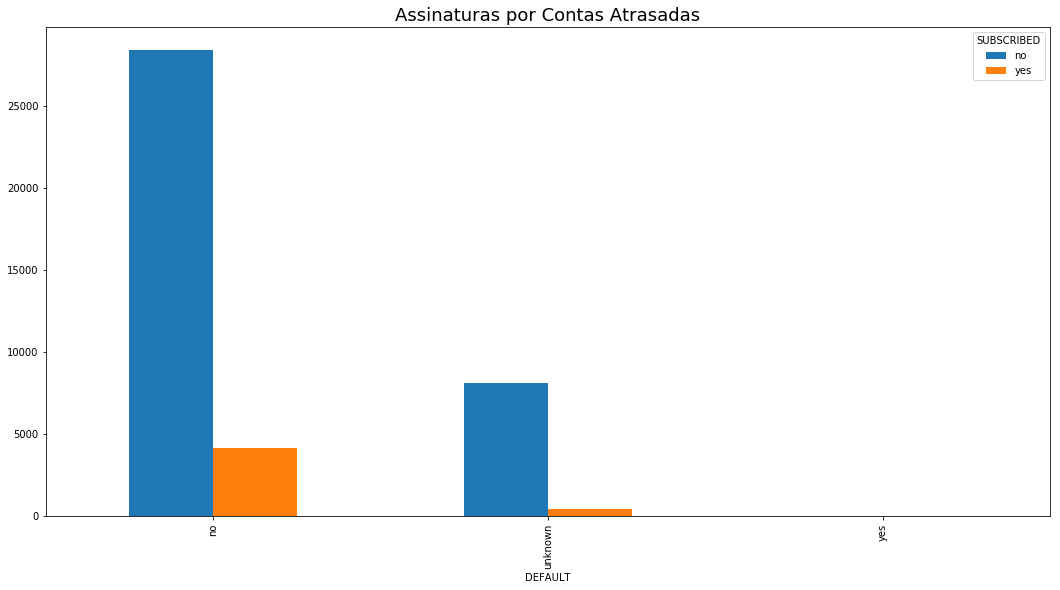

In [13]:
pd.crosstab(df['DEFAULT'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Contas Atrasadas', fontsize=18)

plt.show()

**Análises:** 
- Analisando se a pessoa possui contas atrasadas podemos perceber que os que não possuem tiveram adesao de 12,88% e 4197 pessoas em números absolutos.

### HOUSING

In [23]:
df.groupby('HOUSING').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
HOUSING,,,,,
no,40.044195,260.663677,2.601010,-0.749973,0.161153
unknown,39.951515,250.194949,2.560606,-0.759596,0.184848
yes,40.010011,256.603217,2.539071,-0.734288,0.182610


In [24]:
subscribed_by_housing = df.groupby(['HOUSING', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_housing['perc'] = (subscribed_by_housing / df.shape[0]) * 100

subscribed_by_housing

SUBSCRIBED       perc
HOUSING SUBSCRIBED                       
no      no               16596  40.293289
        yes               2026   4.918908
unknown no                 883   2.143828
        yes                107   0.259784
yes     no               19069  46.297465
        yes               2507   6.086724

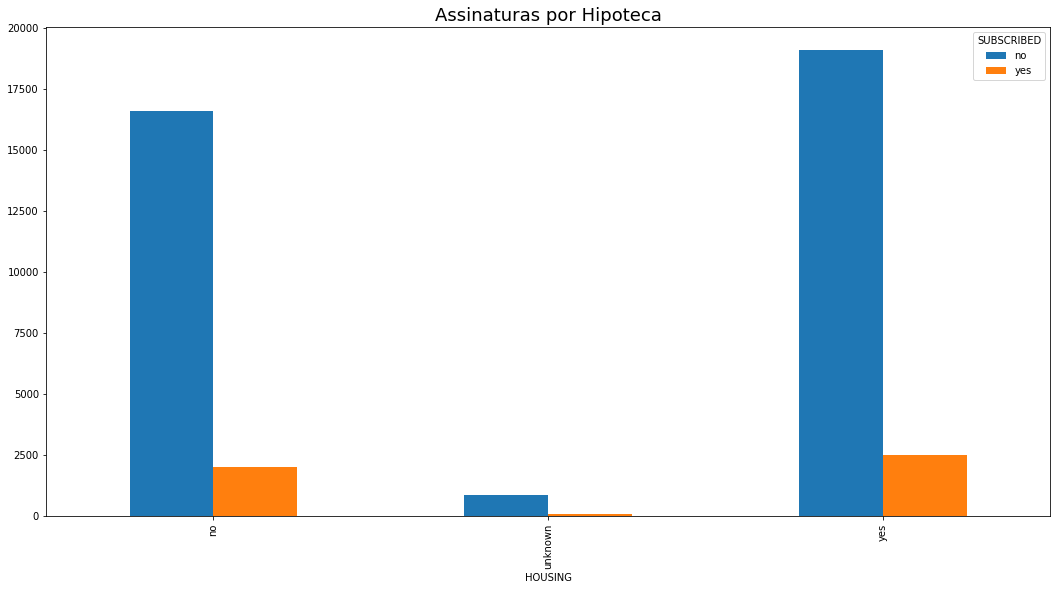

In [14]:
pd.crosstab(df['HOUSING'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Hipoteca', fontsize=18)

plt.show()

**Análises:** 
- Analisando se a pessoa possui hipoteca podemos perceber que não existe grande diferença entre os que tinham ou não tinham hipoteca, pois os que nao tinham hipoteca aderiram em 10,88% com 2026 pessoas e os que tem hipoteca foram 11,61% com 2507 pessoas que aderiram ao serviço.

### LOAN

In [26]:
df.groupby('LOAN').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
LOAN,,,,,
no,40.058822,258.507246,2.561414,-0.739853,0.173078
unknown,39.951515,250.194949,2.560606,-0.759596,0.184848
yes,39.846671,258.359315,2.602273,-0.750800,0.170455


In [27]:
subscribed_by_loan = df.groupby(['LOAN', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_loan['perc'] = (subscribed_by_loan / df.shape[0]) * 100

subscribed_by_loan

SUBSCRIBED       perc
LOAN    SUBSCRIBED                       
no      no               30100  73.079538
        yes               3850   9.347383
unknown no                 883   2.143828
        yes                107   0.259784
yes     no                5565  13.511217
        yes                683   1.658250

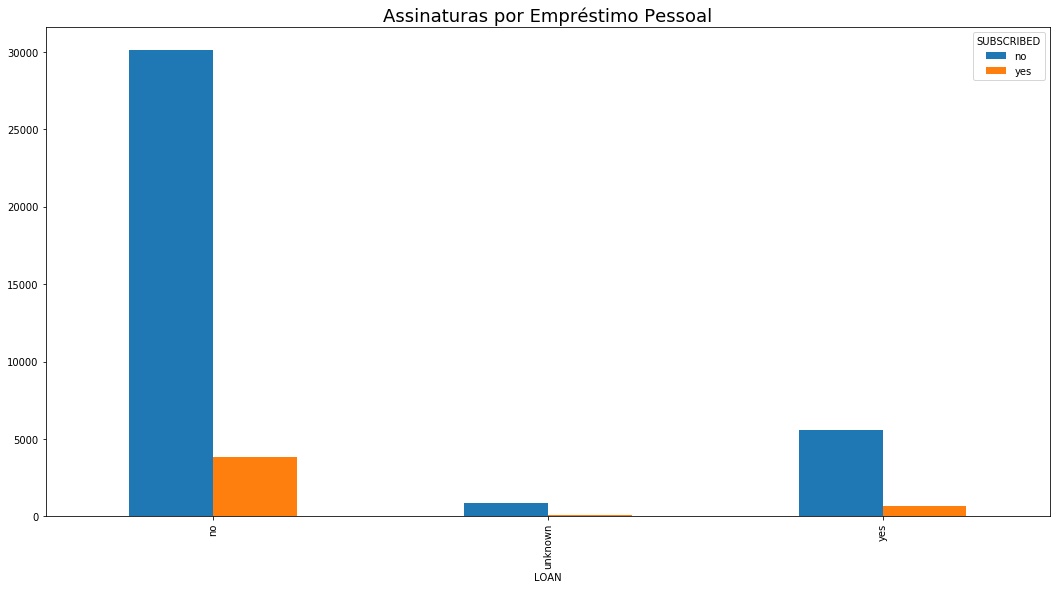

In [15]:
pd.crosstab(df['LOAN'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Empréstimo Pessoal', fontsize=18)

plt.show()

**Análises:** 
- Analisando se a pessoa possui empréstimo pessoal podemos perceber que não existe grande diferença em efetividade entre os que tinham ou não tinham empréstimo, pois os que nao tinham aderiram em 11,34% e os que tem empréstimo foram 10,93% os que aderiram ao serviço. Em números absolutos as pessoas que não tem empréstimos são um número muito maior que os que tem com 3850 pessoas aderindo.

### CONTACT

In [29]:
df.groupby('CONTACT').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
CONTACT,,,,,
cellular,39.968559,263.527846,2.405026,-0.624694,0.252869
telephone,40.120513,249.173823,2.850106,-0.945826,0.034100


In [30]:
subscribed_by_contact = df.groupby(['CONTACT', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_contact['perc'] = (subscribed_by_contact / df.shape[0]) * 100

subscribed_by_contact

SUBSCRIBED       perc
CONTACT   SUBSCRIBED                       
cellular  no               22291  54.120132
          yes               3853   9.354666
telephone no               14257  34.614451
          yes                787   1.910751

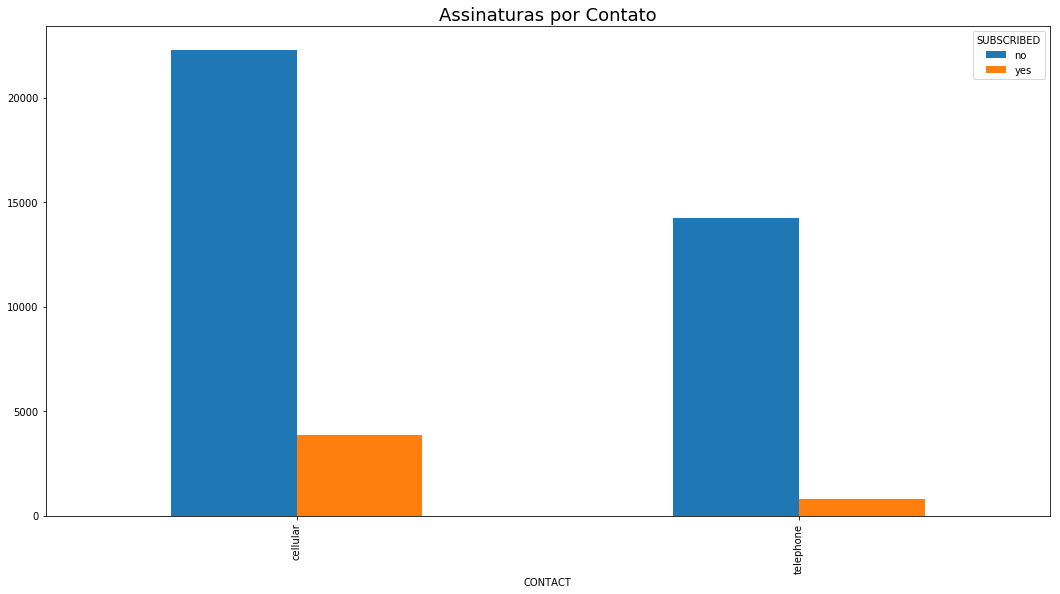

In [16]:
pd.crosstab(df['CONTACT'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Contato', fontsize=18)

plt.show()

**Análises:** 
- Analisando o tipo de contato realizado podemos perceber que tanto em eficiencia como em números absolutos o contato por celular é melhor, tendo 14,74% e 3853 pessoas aderindo contra 5,23% e 787 dos contatos via telefone aderindo.

### MONTH

In [32]:
df.groupby('MONTH').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
MONTH,,,,,
apr,40.593845,293.200608,1.947188,-0.719605,0.323328
aug,41.644221,232.430722,2.666559,-0.737779,0.115410
dec,47.307692,345.609890,2.159341,0.807692,0.615385
jul,39.035545,273.426122,3.160998,-0.850990,0.047115
jun,39.766077,242.561301,3.072208,-0.820233,0.083114
mar,40.778388,245.946886,2.203297,0.289377,0.483516
may,39.031084,261.231752,2.439756,-0.868110,0.164209
nov,40.965618,245.855645,1.909290,-0.719581,0.293587
oct,44.171309,288.367688,1.545961,0.572423,0.647632


In [33]:
subscribed_by_month = df.groupby(['MONTH', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_month['perc'] = (subscribed_by_month / df.shape[0]) * 100

subscribed_by_month

SUBSCRIBED       perc
MONTH SUBSCRIBED                       
apr   no                2093   5.081577
      yes                539   1.308634
aug   no                5523  13.409245
      yes                655   1.590269
dec   no                  93   0.225794
      yes                 89   0.216082
jul   no                6525  15.841993
      yes                649   1.575702
jun   no                4759  11.554336
      yes                559   1.357191
mar   no                 270   0.655531
      yes                276   0.670098
may   no               12883  31.278528
      yes                886   2.151112
nov   no                3685   8.946781
      yes                416   1.010003
oct   no                 403   0.978440
      yes                315   0.764786
sep   no                 314   0.762358
      yes                256   0.621540

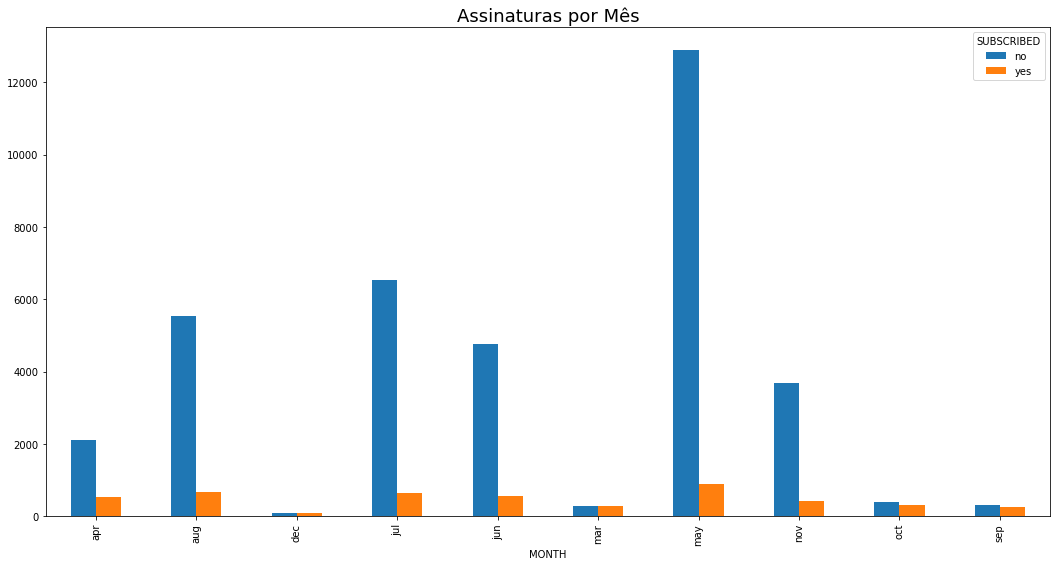

In [17]:
pd.crosstab(df['MONTH'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Mês', fontsize=18)

plt.show()

**Análises:** 
- Analisando os meses em que o contato aconteceu podemos perceber que temos meses em que cerca de 50% dos contatos aderiram ao serviço, mesmo com o número mais baixo de contatos e que mesmo com contatos as vezes 10 vezes maior a efetividade dos contatos cai drasticamente com apenas 10% dos contatos aderindo.

### DAY_OF_WEEK

In [35]:
df.groupby('DAY_OF_WEEK').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
DAY_OF_WEEK,,,,,
fri,40.177846,252.748818,2.719944,-0.776543,0.177463
mon,40.412497,246.568358,2.645760,-0.736434,0.171012
thu,39.591557,265.674591,2.595268,-0.720747,0.174417
tue,40.427441,260.455995,2.426823,-0.729419,0.173053
wed,39.526801,265.883206,2.449840,-0.749570,0.169044


In [36]:
subscribed_by_day_of_week = df.groupby(['DAY_OF_WEEK', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_day_of_week['perc'] = (subscribed_by_day_of_week / df.shape[0]) * 100

subscribed_by_day_of_week

SUBSCRIBED       perc
DAY_OF_WEEK SUBSCRIBED                       
fri         no                6981  16.949111
            yes                846   2.053996
mon         no                7667  18.614645
            yes                847   2.056424
thu         no                7578  18.398563
            yes               1045   2.537147
tue         no                7137  17.327862
            yes                953   2.313781
wed         no                7185  17.444401
            yes                949   2.304069

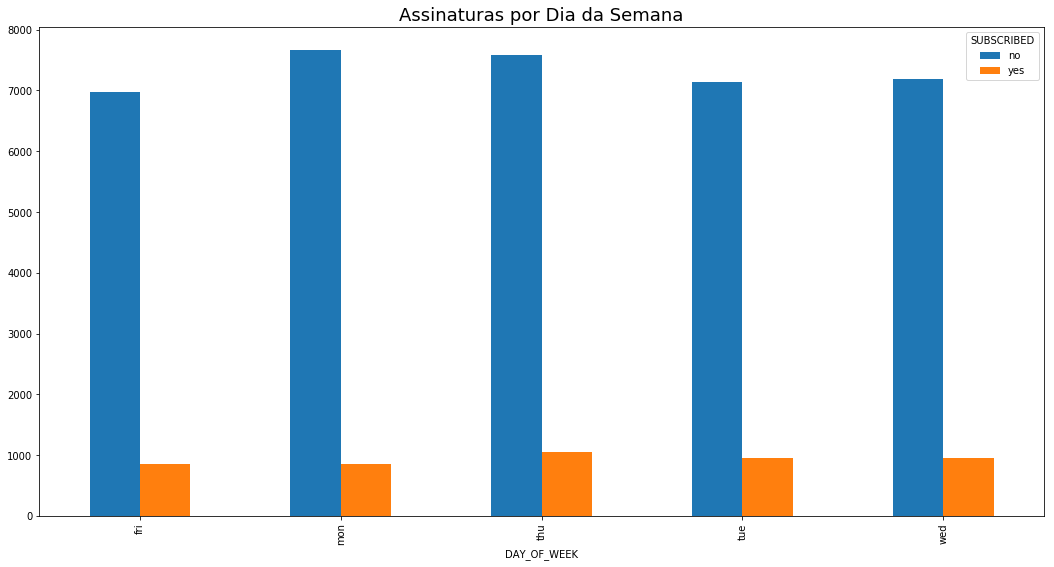

In [18]:
pd.crosstab(df['DAY_OF_WEEK'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Dia da Semana', fontsize=18)

plt.show()

**Análises:** 
- Analisando o dia da semana em que o contato foi realizado não podemos encontrar nenhum tipo de descrepancia de resultados ou eficiencia entre os dias, sendo basicamente irrelevante o dia da semana escolhido para o contato.

### POUTCOME

In [38]:
df.groupby('POUTCOME').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
POUTCOME,,,,,
failure,39.946143,248.112888,2.005174,-0.627940,1.168627
nonexistent,39.956190,257.082192,2.664145,-1.000000,0.000000
success,42.023307,320.941733,1.808449,5.587764,1.569556


In [39]:
subscribed_by_poutcome = df.groupby(['POUTCOME', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_poutcome['perc'] = (subscribed_by_poutcome / df.shape[0]) * 100

subscribed_by_poutcome

SUBSCRIBED       perc
POUTCOME    SUBSCRIBED                       
failure     no                3647   8.854521
            yes                605   1.468874
nonexistent no               32422  78.717102
            yes               3141   7.626008
success     no                 479   1.162960
            yes                894   2.170535

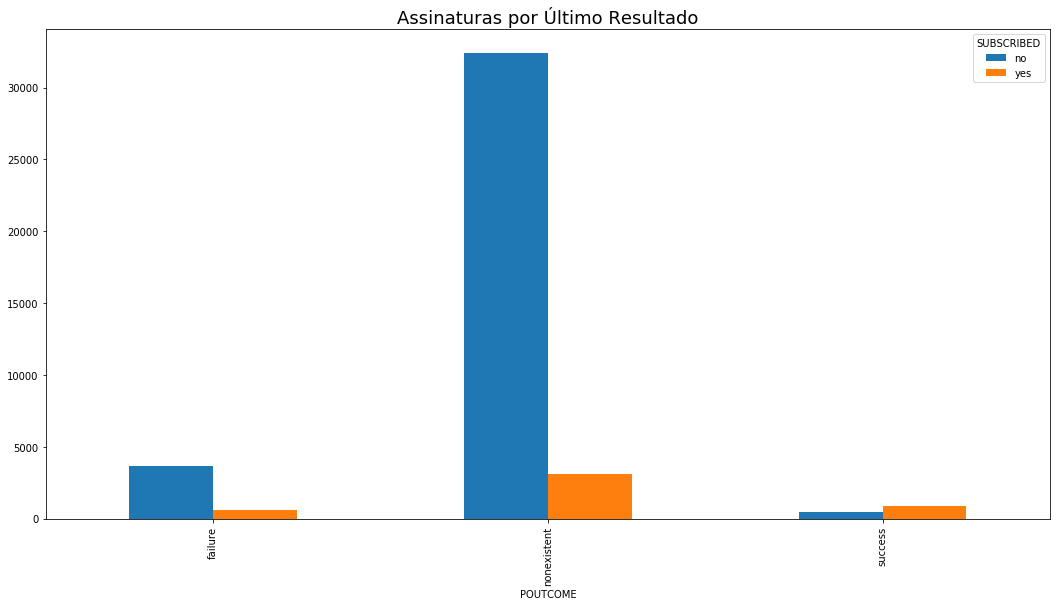

In [19]:
pd.crosstab(df['POUTCOME'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Último Resultado', fontsize=18)

plt.show()

**Análises:**
- Analisando o resultado da última campanha podemos perceber que incríveis 65,11% dos casos de sucesso aderiram ao serviço enquanto que em números absolutos foram os que nao tiveram contato na ultima campanha com 3141 pessoas aderindo.

### EMP_VAR_RATE

In [41]:
df.groupby('EMP_VAR_RATE').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
EMP_VAR_RATE,,,,,
-0_1,40.649471,242.943524,1.895194,-0.951127,0.199566
-0_2,42.100000,121.000000,1.000000,-1.000000,0.100000
-1_1,41.176378,309.234646,1.822047,1.872441,1.193701
-1_7,40.945666,301.712807,1.943079,1.843467,1.051746
-1_8,38.486934,266.205575,2.222997,-0.645253,0.367596
-2_9,40.492483,253.218882,1.785328,-0.129886,0.408900
-3,47.610465,358.668605,2.226744,0.912791,0.645349
-3_4,45.490196,274.387488,1.693744,0.298786,0.606909
1_1,40.327580,265.111297,2.512560,-1.000000,0.000000


In [42]:
df.head()

,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1_1,93.994,-36_4,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1_1,93.994,-36_4,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1_1,93.994,-36_4,no
3,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1_1,93.994,-36_4,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1_1,93.994,-36_4,no


In [6]:
df['EMP_VAR_RATE'] = np.float64(df['EMP_VAR_RATE'].apply(lambda x: x.replace('_', '.')))

In [7]:
df.head()

,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36_4,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36_4,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36_4,no
3,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36_4,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36_4,no


In [23]:
subscribed_by_empvarrate = df.groupby(['EMP_VAR_RATE', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_empvarrate['perc'] = (subscribed_by_empvarrate / df.shape[0]) * 100

subscribed_by_empvarrate

SUBSCRIBED       perc
EMP_VAR_RATE SUBSCRIBED                       
-3.4         no                 617   1.498009
             yes                454   1.102263
-3.0         no                  84   0.203943
             yes                 88   0.213654
-2.9         no                1069   2.595416
             yes                594   1.442168
-1.8         no                7723  18.750607
             yes               1461   3.547150
-1.7         no                 370   0.898320
             yes                403   0.978440
-1.1         no                 334   0.810916
             yes                301   0.730795
-0.2         no                   9   0.021851
             yes                  1   0.002428
-0.1         no                3451   8.378654
             yes                232   0.563271
 1.1         no                7523  18.265029
             yes                240   0.582694
 1.4         no               15368  37.311838
             yes                866   2.102554

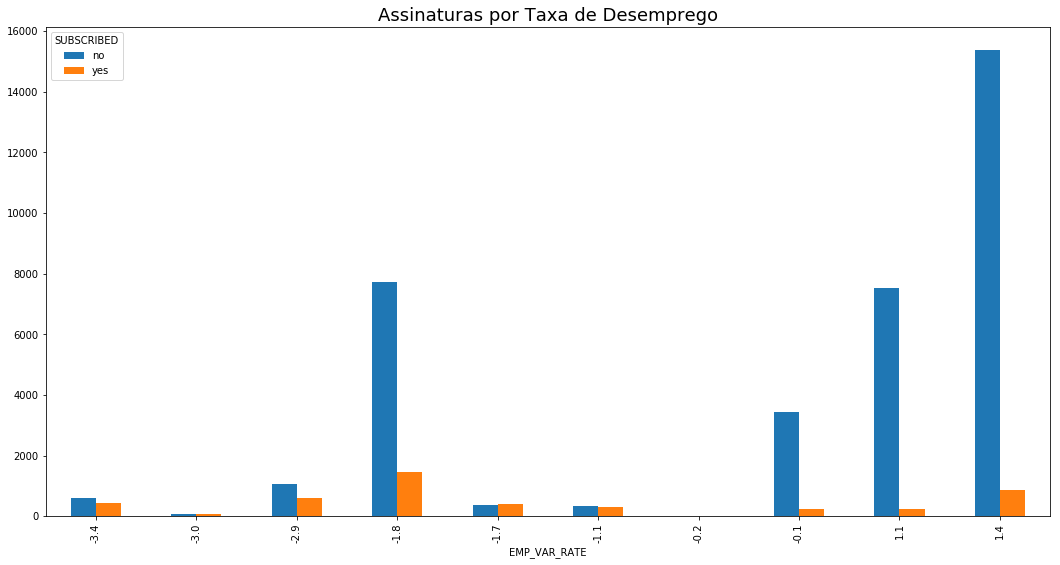

In [24]:
pd.crosstab(df['EMP_VAR_RATE'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Taxa de Desemprego', fontsize=18)

plt.show()

**Análises:** 
- Analisando a taxa de desemprego podemos perceber que como já poderia ser suspeitável, quanto menor a taxa, mais adesão temos a nivel de eficiencia, à exceção do fator -1,8, apesar dele ser o com mais pessoas aderindo com 1461 adesões.

### CONS_PRICE_IDX

In [49]:
df['CONS_PRICE_IDX'].unique()

array(['93.994', '94.465', '93.918', '93.444', '93.798', '93_2', '92.756',
       '92.843', '93.075', '92.893', 92.89299999999999, 92.963, 92.469,
       92.20100000000001, 92.37899999999999, 92.431, 92.649, 92.713,
       93.369, 93.749, 93.876, 94.055, 94.215, 94.027, 94.199, 94.601,
       94.76700000000001], dtype=object)

In [8]:
df['CONS_PRICE_IDX'] = np.float64(df['CONS_PRICE_IDX'].apply(lambda x: str(x).replace('_', '.')))

In [9]:
df['CONS_PRICE_IDX'].unique()

array([93.994, 94.465, 93.918, 93.444, 93.798, 93.2  , 92.756, 92.843,
       93.075, 92.893, 92.893, 92.963, 92.469, 92.201, 92.379, 92.431,
       92.649, 92.713, 93.369, 93.749, 93.876, 94.055, 94.215, 94.027,
       94.199, 94.601, 94.767])

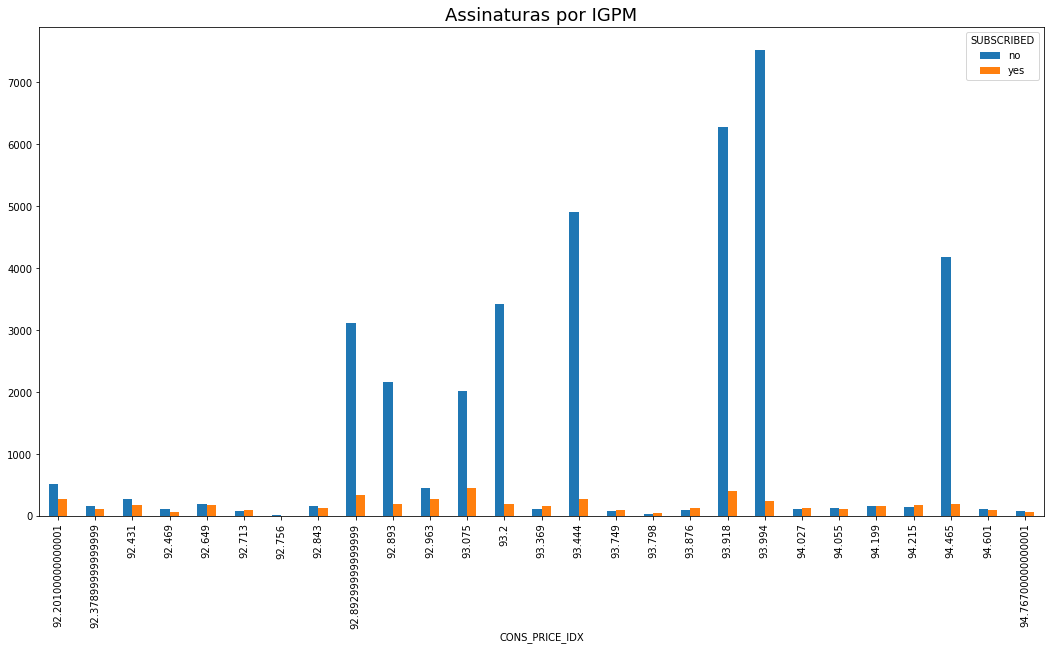

In [27]:
pd.crosstab(df['CONS_PRICE_IDX'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por IGPM', fontsize=18)

plt.show()

**Análises:** 
- Analisando o IGPM podemos perceber que a maioria dos contatos e adesões foram realizadas entre 92,89222222222 e 97,994.

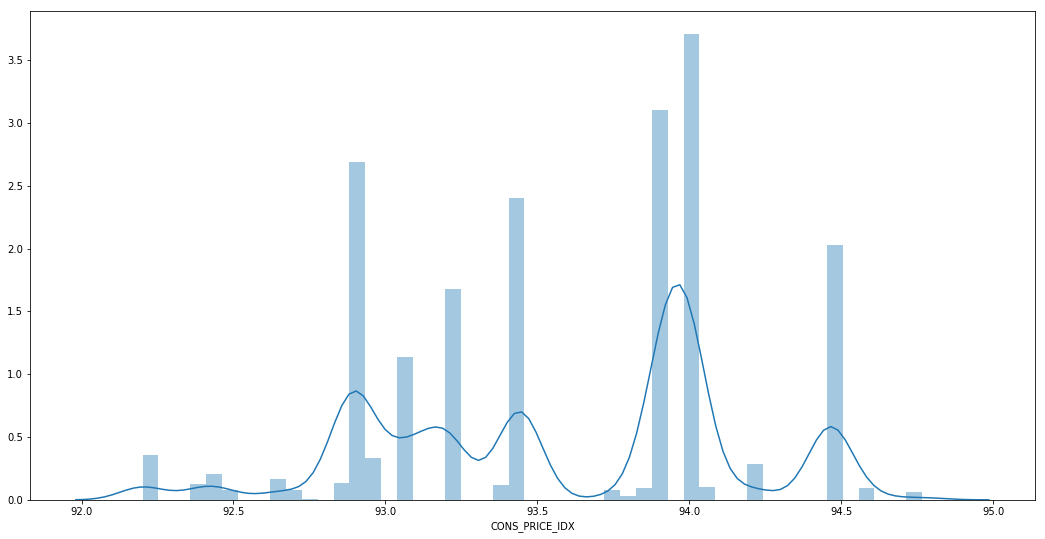

In [80]:
plt.figure(figsize=(18, 9))

sns.distplot(df['CONS_PRICE_IDX'])

plt.show()

### CONS_CONF_IDX

In [10]:
df['CONS_CONF_IDX'] = np.float64(df['CONS_CONF_IDX'].apply(lambda x: str(x).replace('_', '.')))

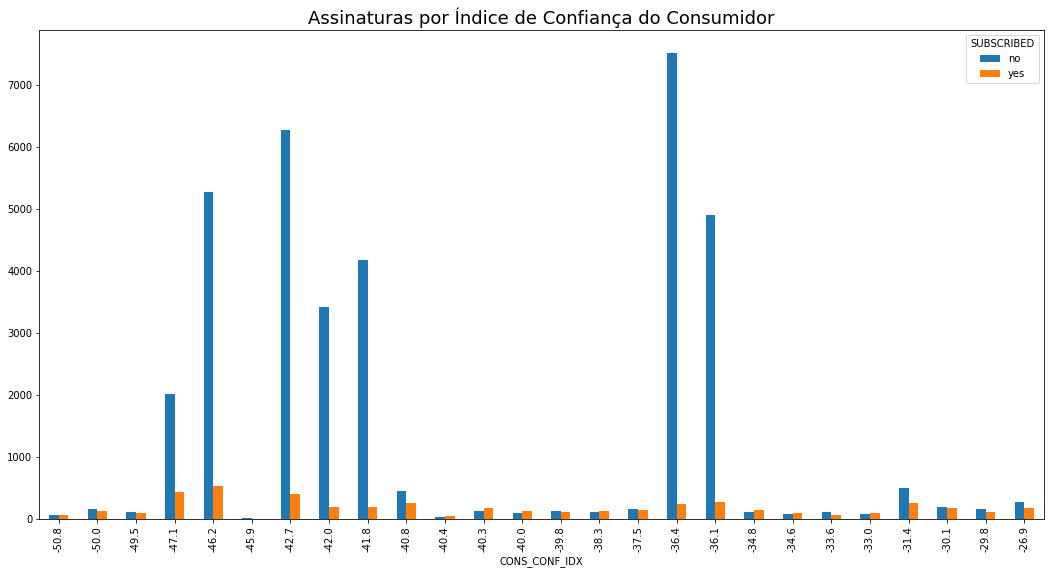

In [50]:
pd.crosstab(df['CONS_CONF_IDX'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Índice de Confiança do Consumidor', fontsize=18)

plt.show()

**Análises:** 
- Analisando o Índice de confiança do consumidor podemos perceber que a maioria dos contatos e adesões foram realizadas entre -47,1 e -36,1, apesar de claramente não serem os índices mais eficiente.

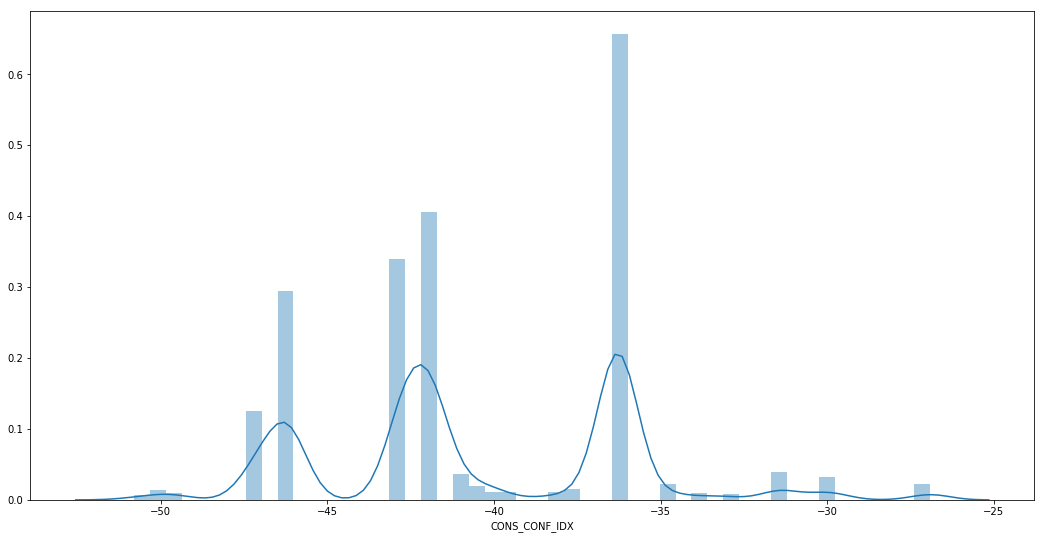

In [84]:
plt.figure(figsize=(18, 9))

sns.distplot(df['CONS_CONF_IDX'])

plt.show()

### AGE

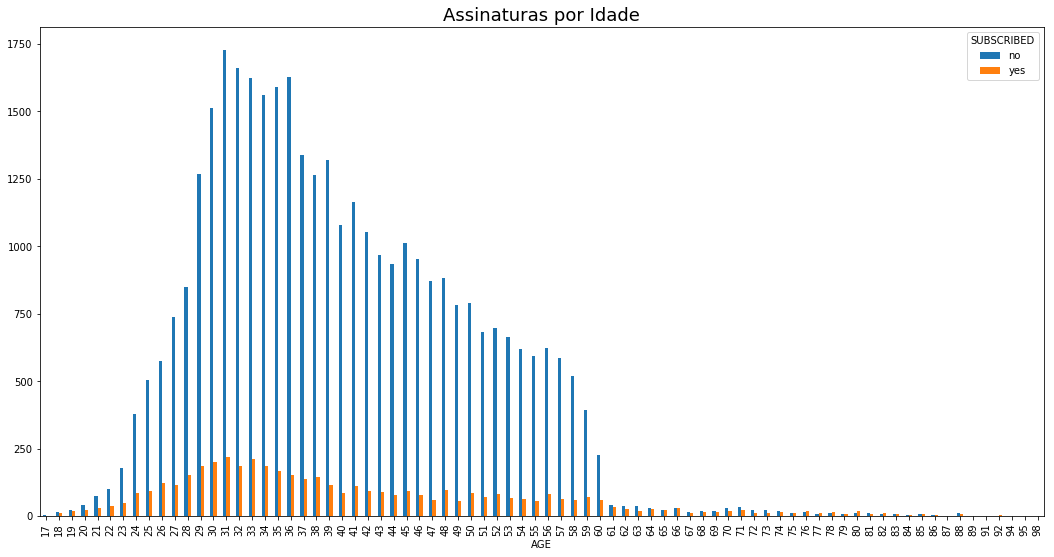

In [85]:
pd.crosstab(df['AGE'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Idade', fontsize=18)

plt.show()

**Análises:** 
- Analisando as idades dos nossos possiveis consumidores podemos perceber que a maioria dos contatos e adesões foram realizadas entre 23 e 60 anos não sendo porem as idades mais eficientes a nivel de contato por adesão.

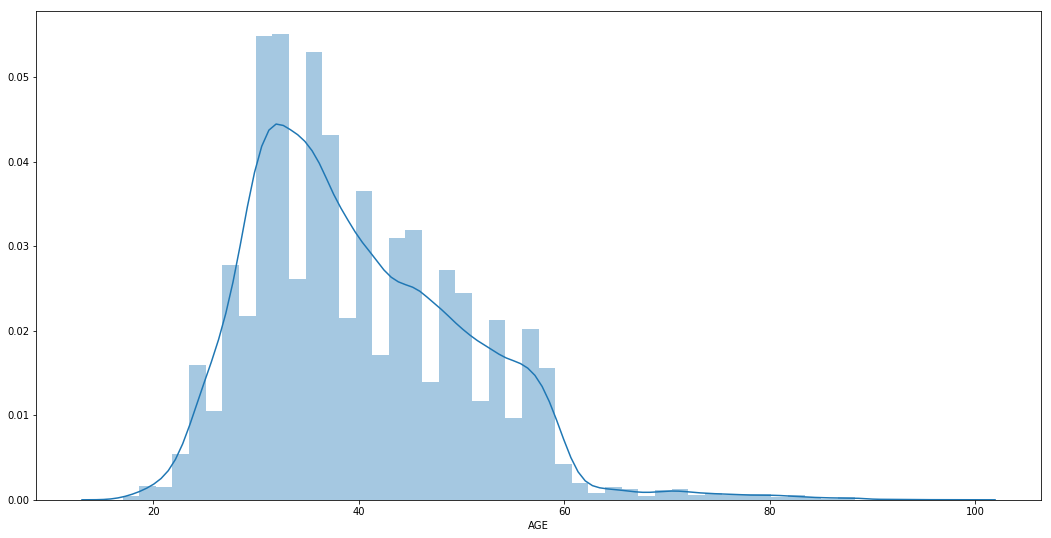

In [86]:
plt.figure(figsize=(18, 9))

sns.distplot(df['AGE'])

plt.show()

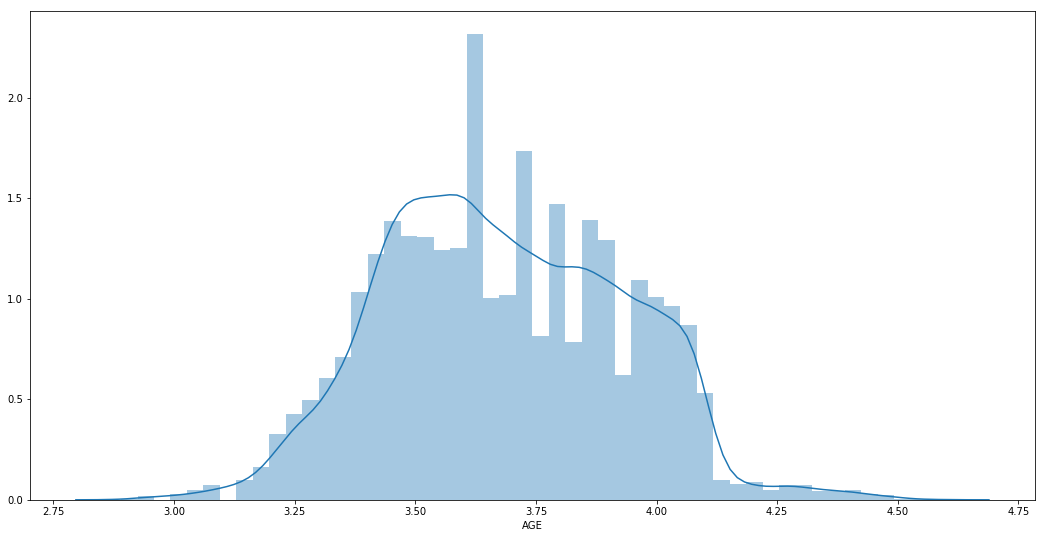

In [88]:
plt.figure(figsize=(18, 9))

sns.distplot(np.log1p(df['AGE']))

plt.show()

### DURATION

In [28]:
df['DURATION'].describe()

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: DURATION, dtype: float64

In [12]:
df['DURATION_RANGE'] = df['DURATION'].apply(duration_classifier)

In [13]:
df.head()

,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED,DURATION_RANGE
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,no,[Maior que 100]
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,no,[Maior que 100]
2,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,no,[Maior que 100]
3,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,no,[Maior que 100]
4,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,no,[Maior que 100]


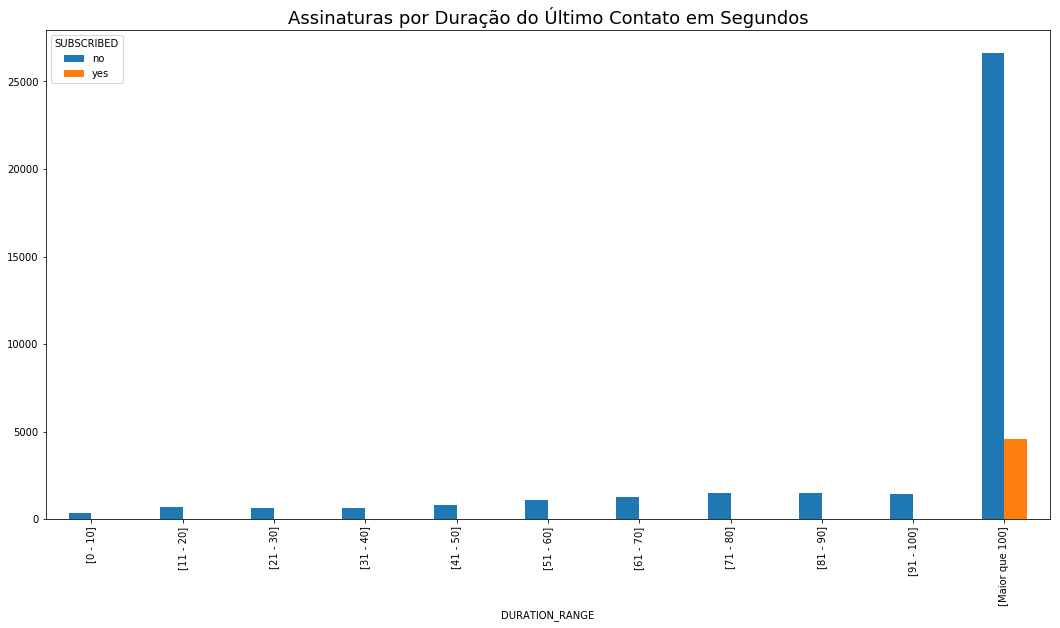

In [32]:
pd.crosstab(df['DURATION_RANGE'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Duração do Último Contato em Segundos', fontsize=18)

plt.show()

**Análises:** 
- Analisando a Duração dos contatos podemos perceber que quanto mais longo o contato, mais chance dos consumidores aderirem ao serviço. Precisaremos normalizar esse dado, para diminuir o impacto na formação dos modelos.

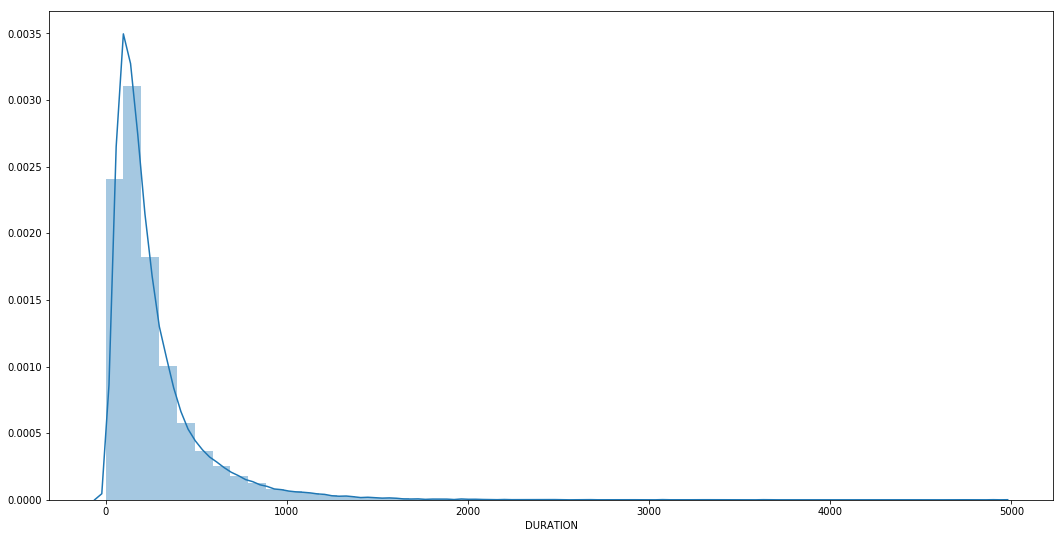

In [89]:
plt.figure(figsize=(18, 9))

sns.distplot(df['DURATION'])

plt.show()

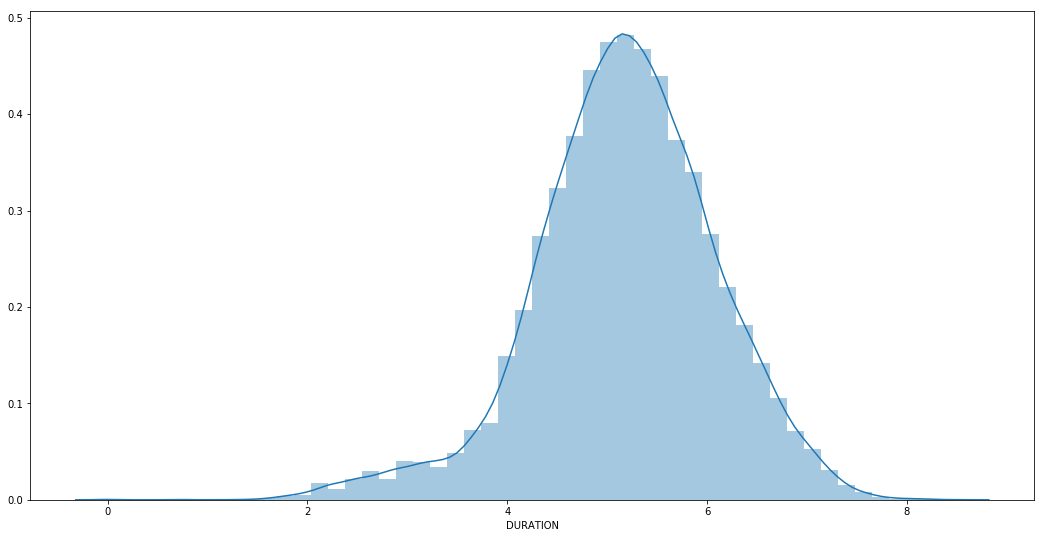

In [90]:
plt.figure(figsize=(18, 9))

sns.distplot(np.log1p(df['DURATION']))

plt.show()

**Análises:**
- Não foi possível a aplicação do log por causa de valores zerados, por isso foi aplicado log1p
- Após a aplicação do log1p a distribuição do atributo *DURATION* ficou mais parecido com uma distribuição normal

### CAMPAIGN

In [113]:
df['CAMPAIGN'].describe()

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: CAMPAIGN, dtype: float64

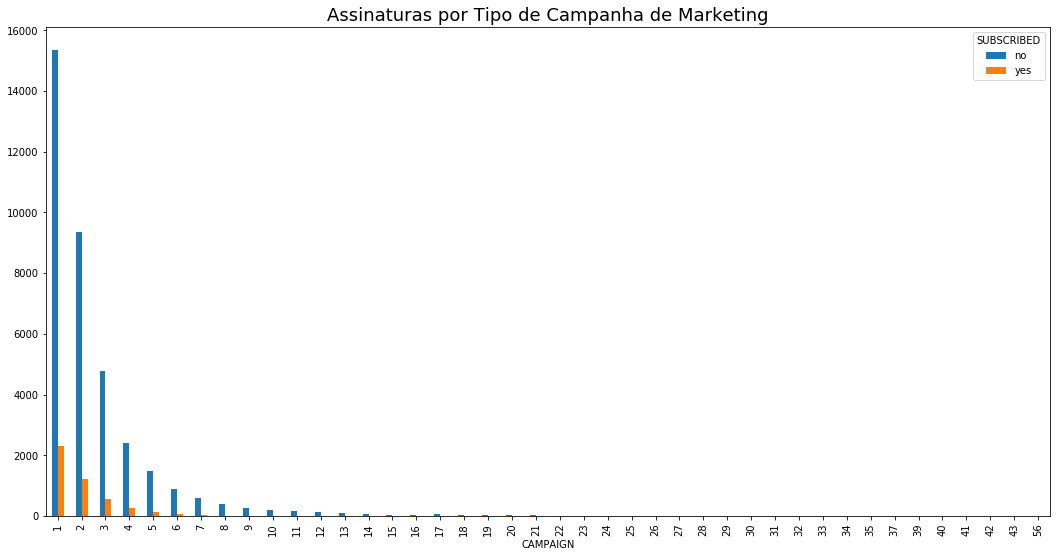

In [114]:
pd.crosstab(df['CAMPAIGN'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Tipo de Campanha de Marketing', fontsize=18)

plt.show()

**Análises:**
- Analisando a o tipo de campanha de marketing podemos perceber que apenas os modelos 1 a 7 obtiveram sucesso na adesão de clientes com uma eficiencia semelhante.

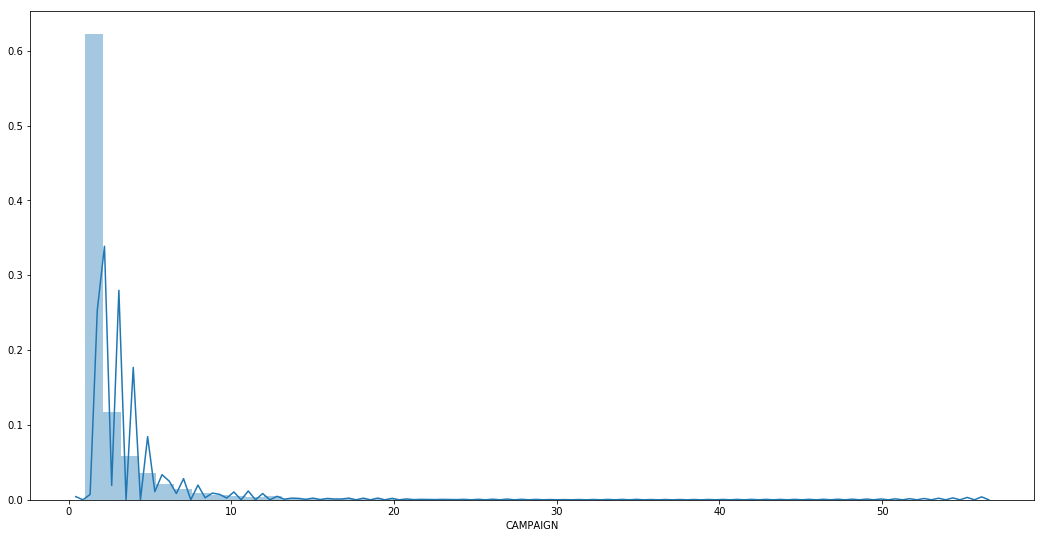

In [115]:
plt.figure(figsize=(18, 9))

sns.distplot(df['CAMPAIGN'])

plt.show()

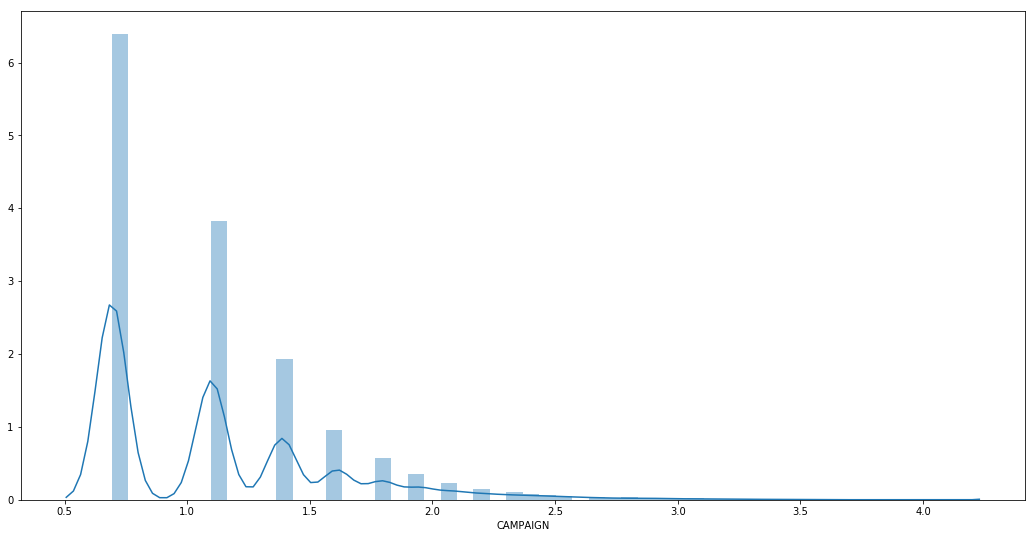

In [116]:
plt.figure(figsize=(18, 9))

sns.distplot(np.log1p(df['CAMPAIGN']))

plt.show()

### PDAYS

In [117]:
df['PDAYS'].describe()

count    41188.000000
mean        -0.741988
std          1.510327
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         27.000000
Name: PDAYS, dtype: float64

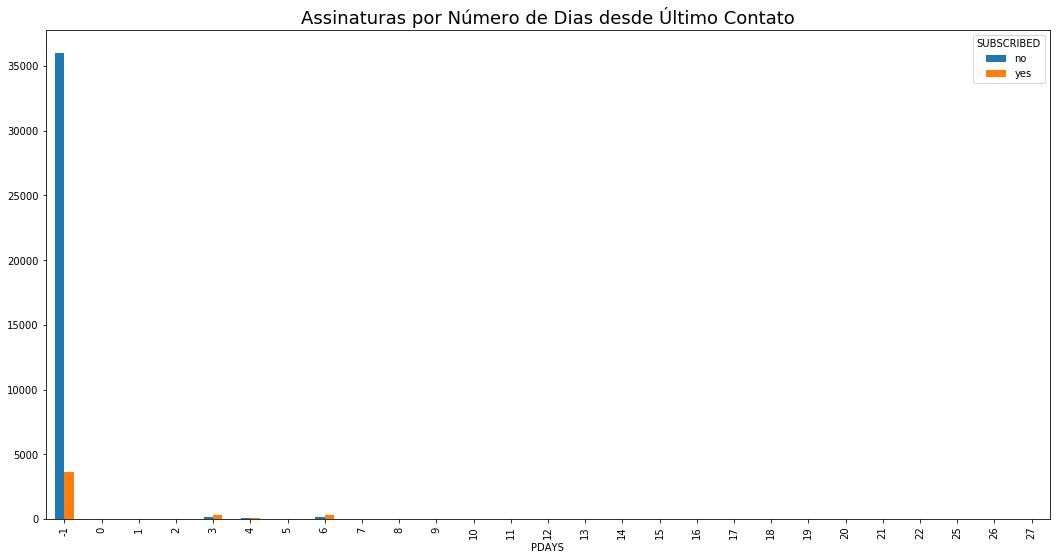

In [118]:
pd.crosstab(df['PDAYS'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Número de Dias desde Último Contato', fontsize=18)

plt.show()

**Análises:** 
- Analisando o Número de Dias desde Último Contato podemos perceber que quanto o mais eficiente caso exista o contato é esperar de 3 a 6 dias antes de retorna-lo.

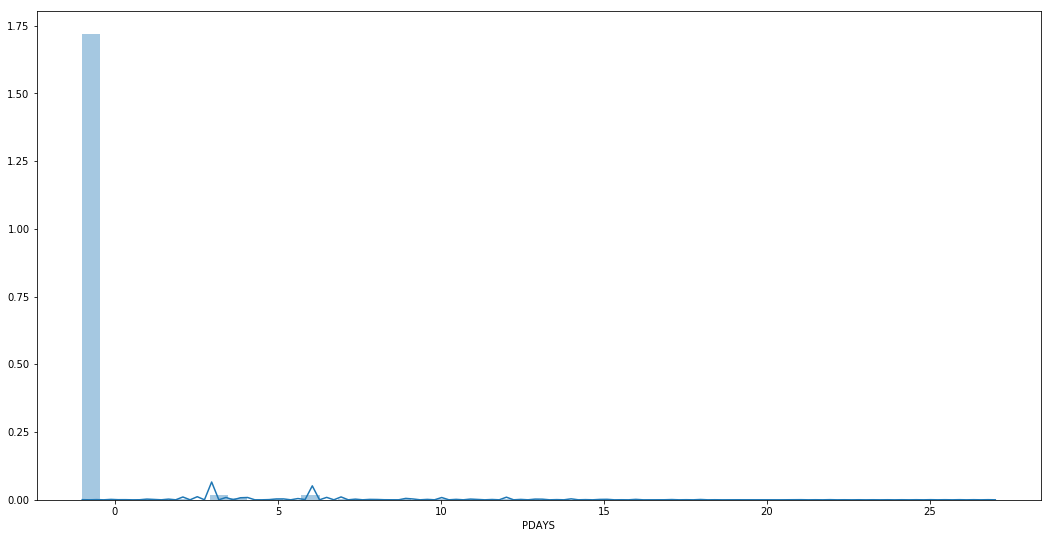

In [120]:
plt.figure(figsize=(18, 9))

sns.distplot(df['PDAYS'])

plt.show()

In [33]:
df.loc[df['PDAYS'] <= 0, 'PDAYS'].value_counts()

-1    39673
 0       15
Name: PDAYS, dtype: int64

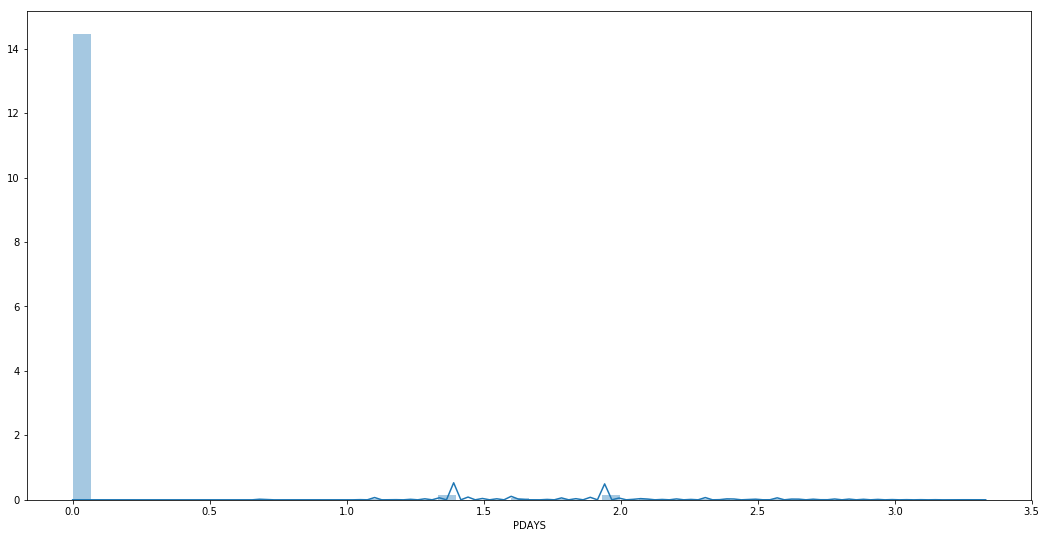

In [34]:
plt.figure(figsize=(18, 9))

sns.distplot(np.log1p(df['PDAYS'].replace(-1, 0)))

plt.show()

### PREVIOUS

In [127]:
df['PREVIOUS'].describe()

count    41188.000000
mean         0.172963
std          0.494901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: PREVIOUS, dtype: float64

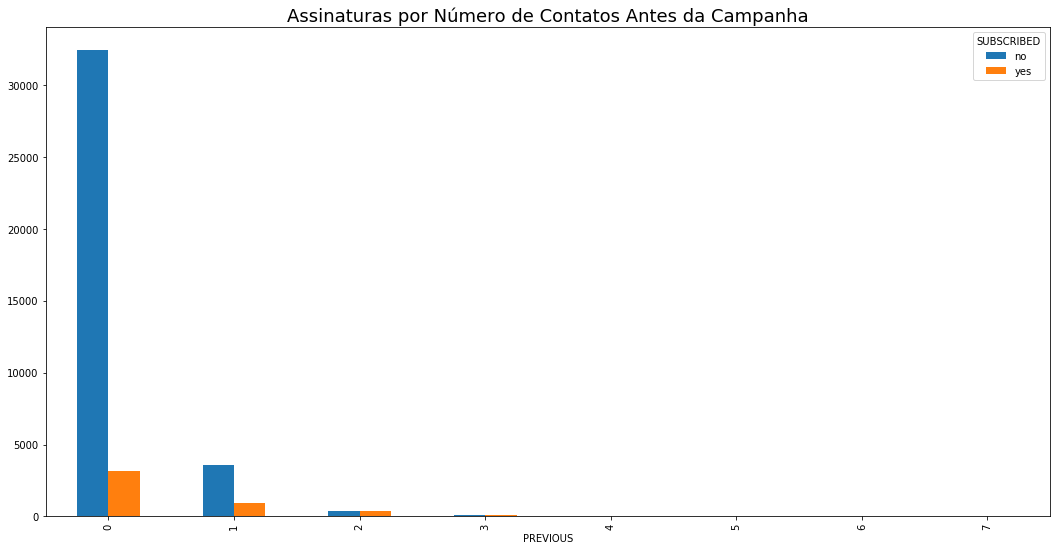

In [128]:
pd.crosstab(df['PREVIOUS'], df['SUBSCRIBED']).plot(kind='bar', figsize=(18, 9))

plt.title('Assinaturas por Número de Contatos Antes da Campanha', fontsize=18)

plt.show()

**Análises:** 
- Analisando o Número de Contatos antes da Campanha podemos perceber que quanto o mais eficiente caso exista o contato é relizar ao menos 1 contato.

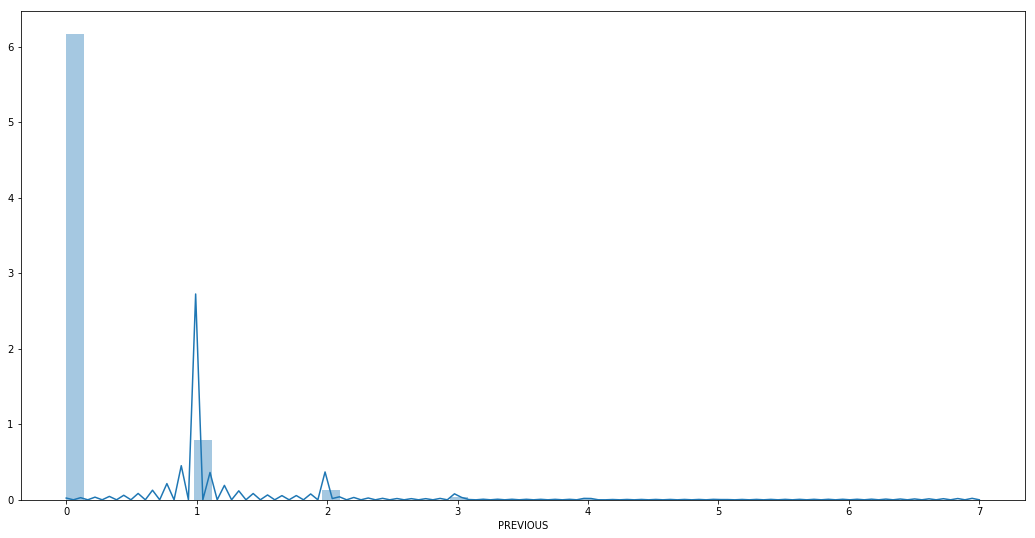

In [129]:
plt.figure(figsize=(18, 9))

sns.distplot(df['PREVIOUS'])

plt.show()

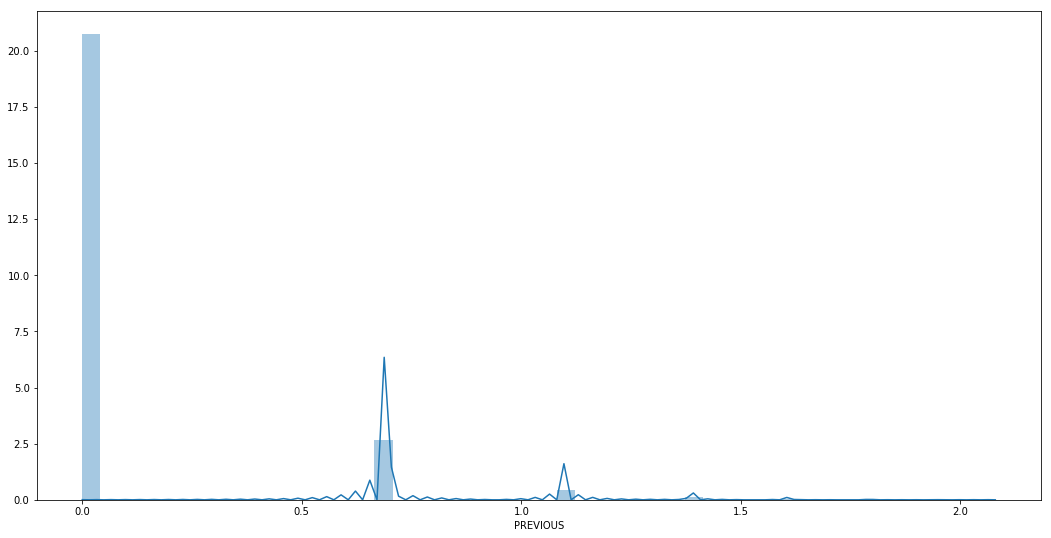

In [130]:
plt.figure(figsize=(18, 9))

sns.distplot(np.log1p(df['PREVIOUS']))

plt.show()

### SUBSCRIBED

no     36548
yes     4640
Name: SUBSCRIBED, dtype: int64


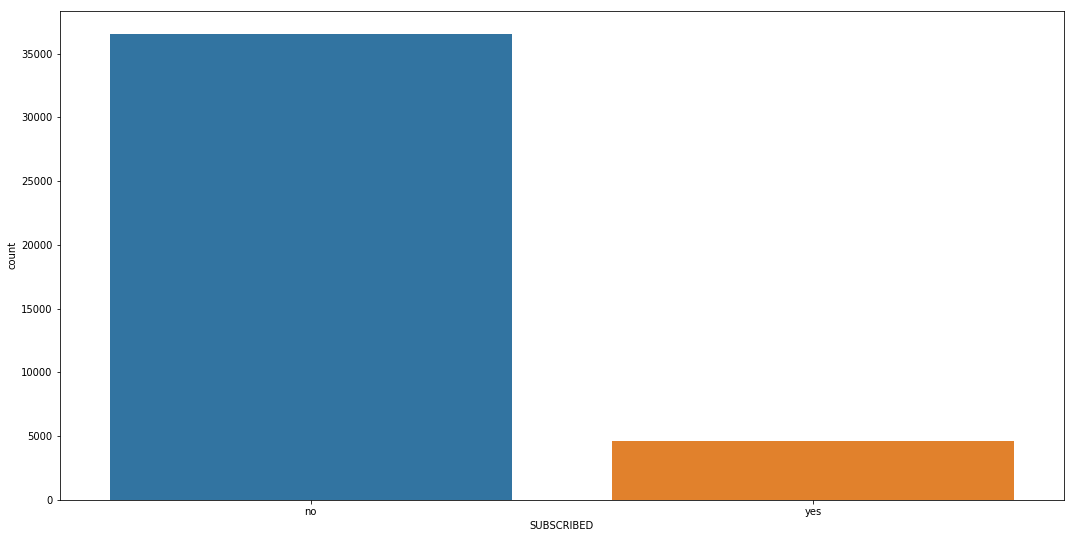

In [42]:
print(df['SUBSCRIBED'].value_counts())

plt.figure(figsize=(18, 9))

sns.countplot(df['SUBSCRIBED'])

plt.show()

**Análises:**
- Variável alvo desbalanceada

## Transformações

### Normalização

In [14]:
df.select_dtypes(exclude=np.object).head()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX
0,56,261,1,-1,0,1.1,93.994,-36.4
1,57,149,1,-1,0,1.1,93.994,-36.4
2,37,226,1,-1,0,1.1,93.994,-36.4
3,40,151,1,-1,0,1.1,93.994,-36.4
4,56,307,1,-1,0,1.1,93.994,-36.4


In [15]:
df.select_dtypes(exclude=np.object).describe()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,-0.741988,0.172963,0.081886,93.575664,-40.502600
std,10.42125,259.279249,2.770014,1.510327,0.494901,1.570960,0.578840,4.628198
min,17.00000,0.000000,1.000000,-1.000000,0.000000,-3.400000,92.201000,-50.800000
25%,32.00000,102.000000,1.000000,-1.000000,0.000000,-1.800000,93.075000,-42.700000
50%,38.00000,180.000000,2.000000,-1.000000,0.000000,1.100000,93.749000,-41.800000
75%,47.00000,319.000000,3.000000,-1.000000,0.000000,1.400000,93.994000,-36.400000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000


In [16]:
cols_to_scale = ['AGE', 'CAMPAIGN', 'PDAYS', 'CONS_PRICE_IDX', 'CONS_CONF_IDX']

scaler = StandardScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [17]:
df['DURATION'] = np.log1p(df['DURATION'])

### LabelEncoder

In [18]:
cols = ['MARITAL_STATUS', 'DEFAULT', 'HOUSING', 'LOAN', 'CONTACT', 'POUTCOME', 'DURATION_RANGE']

for i in cols:
    label = LabelEncoder()
    df[i] = label.fit_transform(df[i])

### SUBSCRIBED

In [29]:
if df['SUBSCRIBED'].dtype != np.int64:
    df['SUBSCRIBED'] = df['SUBSCRIBED'].apply(lambda x: 1 if x == 'yes' else 0)

### MONTH

In [31]:
if df['MONTH'].dtype != np.int64:
    df['MONTH'] = df['MONTH'].apply(lambda x: strptime(x,'%b').tm_mon)

### DAY_OF_WEEK

In [32]:
if df['DAY_OF_WEEK'].dtype != np.int64:
    df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].apply(lambda x: strptime(x,'%a').tm_wday)

In [33]:
df.head()

,AGE,MARITAL_STATUS,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,...,JOB_unemployed,JOB_unknown,EDUCATION_basic_4y,EDUCATION_basic_6y,EDUCATION_basic_9y,EDUCATION_high_school,EDUCATION_illiterate,EDUCATION_professional_course,EDUCATION_university_degree,EDUCATION_unknown
0,1.533034,1,0,0,0,1,5,0,5.568345,-0.565922,...,0,0,1,0,0,0,0,0,0,0
1,1.628993,1,1,0,0,1,5,0,5.010635,-0.565922,...,0,0,0,0,0,1,0,0,0,0
2,-0.290186,1,0,2,0,1,5,0,5.424950,-0.565922,...,0,0,0,0,0,1,0,0,0,0
3,-0.002309,1,0,0,0,1,5,0,5.023881,-0.565922,...,0,0,0,1,0,0,0,0,0,0
4,1.533034,1,0,0,2,1,5,0,5.730100,-0.565922,...,0,0,0,0,0,1,0,0,0,0


### DUMMY

In [23]:
df = pd.get_dummies(df)

### Save Dataframe

In [24]:
save(df, 'df_transformado')

Objeto salvo com sucesso


## Modelagem

### Heatmap Correlation

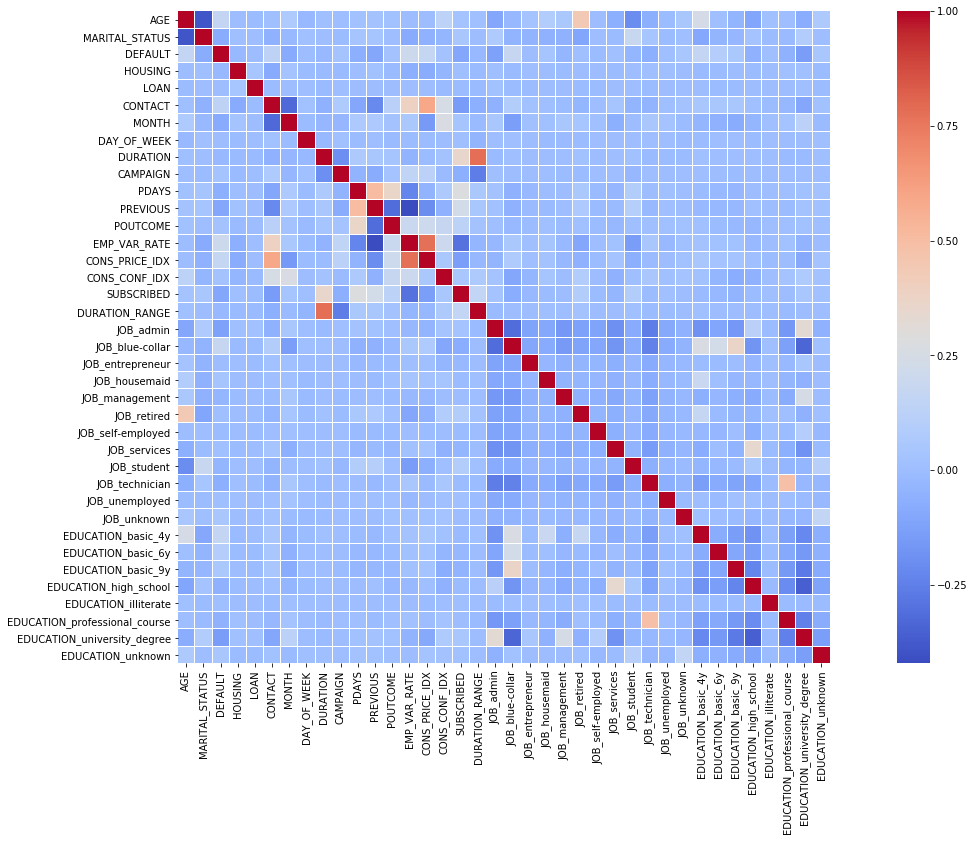

In [96]:
plt.figure(figsize=(24, 12))

sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.01, square=True)

plt.show()

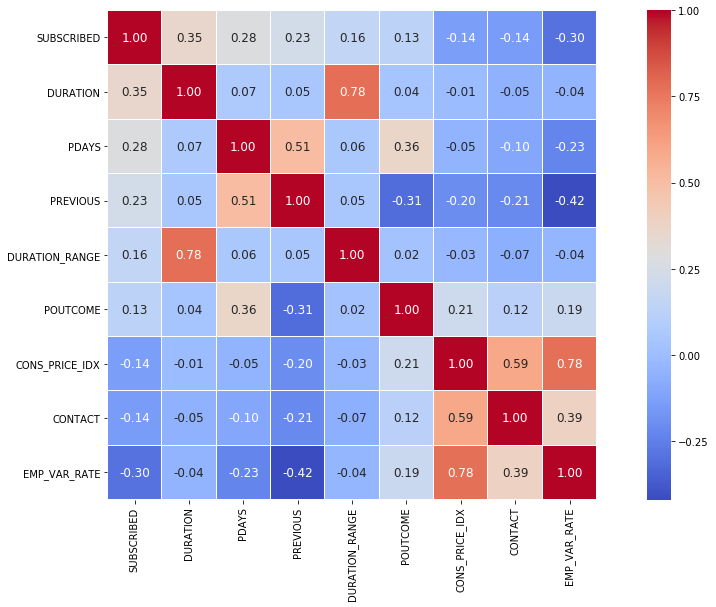

In [34]:
corr = df.corr()['SUBSCRIBED'].sort_values(ascending=False)

idx = np.where(np.abs(corr.values) >= 0.1)

corr_cols = corr.index[idx]

coef_corr = df[corr_cols].corr().T.values

plt.figure(figsize=(18, 9))

sns.heatmap(
    coef_corr, 
    cmap='coolwarm', 
    linewidths=0.01, 
    annot_kws={'size': 12}, 
    cbar=True, 
    annot=True, 
    square=True, 
    fmt='.2f', 
    yticklabels=corr_cols.values, 
    xticklabels=corr_cols.values
)

plt.show()

### Divisão dos dados

In [35]:
X, y = df.drop(['SUBSCRIBED'], axis=1), df['SUBSCRIBED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

### Comparação de modelos

In [36]:
modelos = []

modelos.append(('LogisticRegression', LogisticRegression(random_state=SEED)))
modelos.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED)))
modelos.append(('MLPClassifier', MLPClassifier(random_state=SEED)))
modelos.append(('RandomForestClassifier', RandomForestClassifier(random_state=SEED)))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=SEED)))

--------------------------------------------------
LogisticRegression
--------------------------------------------------
0.9126287676459367 0.90515497288986 0.007473794756076679

--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------
1.0 0.8843570445901109 0.11564295540988911

--------------------------------------------------
MLPClassifier
--------------------------------------------------
0.9389545974818772 0.9022416444120741 0.036712953069803045

--------------------------------------------------
RandomForestClassifier
--------------------------------------------------
0.9930630224411224 0.9029699765315206 0.09009304590960188

--------------------------------------------------
GradientBoostingClassifier
--------------------------------------------------
0.9208490860532066 0.90928218823339 0.011566897819816568



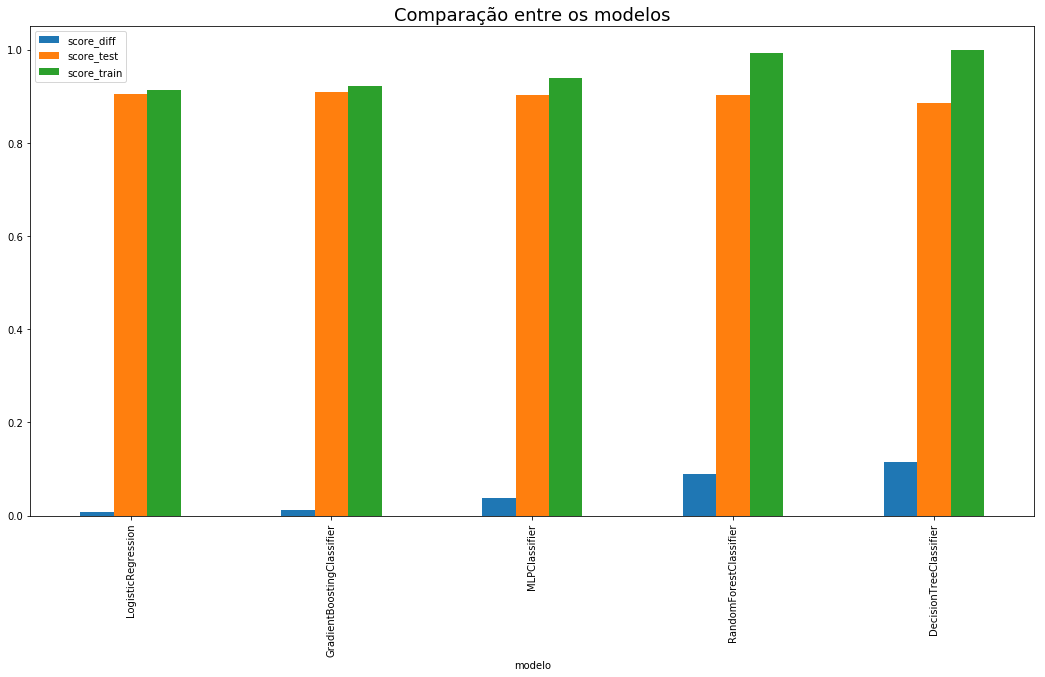

In [101]:
results = []

for i, m in enumerate(modelos):
    print('-' * 80)
    print(m[0])
    print('-' * 80)
    
    clf = m[1]
    
    clf.fit(X_train, y_train)
    
    s_train, s_test = clf.score(X_train, y_train), clf.score(X_test, y_test)
    s_diff = s_train - s_test
    
    results.append({'modelo': m[0], 'score_train': s_train, 'score_test': s_test, 'score_diff': s_diff})
    
    print('{} {} {}\n'.format(s_train, s_test, s_diff))
    
df_results = pd.DataFrame(results)

df_results.set_index('modelo').sort_values(by='score_diff').plot(kind='bar', figsize=(18, 9))

plt.title('Comparação entre os modelos', fontsize=18)

plt.show()

**Análises:**
- De acordo com os resultados acimas, utilizaremos o modelo GradientBoosting por ter um valor de score alto tanto para a base de treino quanto para a de teste e a diferença entre o score de treino e teste são pequenos.
- Apesar da DecisionTree e RandomForest terem um score de 99% para a base de treino, o score da base de teste possui um valor muito baixo, caracterizando um overfitting.

### GradientBoostingClassifier

In [37]:
results = []

#### Sem feature selection

In [41]:
clf_1 = GradientBoostingClassifier(random_state=SEED)

clf_1.fit(X_train, y_train)

y_pred_1 = clf_1.predict(X_test)
y_prob_1 = clf_1.predict_proba(X_test)

report(y_test, y_pred_1)

Confusion Matrix:

[[10563   336]
 [  785   673]]
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10899
           1       0.67      0.46      0.55      1458

    accuracy                           0.91     12357
   macro avg       0.80      0.72      0.75     12357
weighted avg       0.90      0.91      0.90     12357



**Análises:** ...

In [42]:
y_prob_1_t03 = set_threshold(y_prob_1[:, 1], 0.3, True)
y_prob_1_t05 = set_threshold(y_prob_1[:, 1], 0.5, True)
y_prob_1_t07 = set_threshold(y_prob_1[:, 1], 0.7, True)

y_pred_1_t03 = set_threshold(y_prob_1_t03, 0.3)
y_pred_1_t05 = set_threshold(y_prob_1_t05, 0.5)
y_pred_1_t07 = set_threshold(y_prob_1_t07, 0.7)

In [43]:
set_results(
    'GradientBoosting sem Feature Selection', 
    precision_score(y_test, y_pred_1_t03),
    recall_score(y_test, y_pred_1_t03),
    roc_auc_score(y_test, y_prob_1_t03),
    0.3
)

set_results(
    'GradientBoosting sem Feature Selection', 
    precision_score(y_test, y_pred_1_t05),
    recall_score(y_test, y_pred_1_t05),
    roc_auc_score(y_test, y_prob_1_t05),
    0.5
)

set_results(
    'GradientBoosting sem Feature Selection', 
    precision_score(y_test, y_pred_1_t07),
    recall_score(y_test, y_pred_1_t07),
    roc_auc_score(y_test, y_prob_1_t07),
    0.7
)

#### Com feature selection

In [44]:
clf_2 = GradientBoostingClassifier(random_state=SEED)
clf_2.fit(X_train, y_train)

sfm = SelectFromModel(clf_2, threshold=0.05)
sfm.fit(X_train, y_train)

sfm.get_support(indices=True)

array([ 8, 10, 13, 15], dtype=int64)

In [45]:
for i in sfm.get_support(indices=True):
    print(X.columns[i])

DURATION
PDAYS
EMP_VAR_RATE
CONS_CONF_IDX


In [46]:
X_imp_train = sfm.transform(X_train)
X_imp_test = sfm.transform(X_test)

In [47]:
clf_imp_2 = GradientBoostingClassifier(random_state=SEED)
clf_imp_2.fit(X_imp_train, y_train)

y_pred_imp_2 = clf_imp_2.predict(X_imp_test)
y_prob_imp_2 = clf_imp_2.predict_proba(X_imp_test)

report(y_test, y_pred_imp_2)

Confusion Matrix:

[[10536   363]
 [  759   699]]
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10899
           1       0.66      0.48      0.55      1458

    accuracy                           0.91     12357
   macro avg       0.80      0.72      0.75     12357
weighted avg       0.90      0.91      0.90     12357



**Análises:** ...

In [48]:
y_prob_imp_2_t03 = set_threshold(y_prob_imp_2[:, 1], 0.3, True)
y_prob_imp_2_t05 = set_threshold(y_prob_imp_2[:, 1], 0.5, True)
y_prob_imp_2_t07 = set_threshold(y_prob_imp_2[:, 1], 0.7, True)

y_pred_imp_2_t03 = set_threshold(y_prob_imp_2_t03, 0.3)
y_pred_imp_2_t05 = set_threshold(y_prob_imp_2_t05, 0.5)
y_pred_imp_2_t07 = set_threshold(y_prob_imp_2_t07, 0.7)

In [49]:
set_results(
    'GradientBoosting com Feature Selection', 
    precision_score(y_test, y_pred_imp_2_t03),
    recall_score(y_test, y_pred_imp_2_t03),
    roc_auc_score(y_test, y_prob_imp_2_t03),
    0.3
)

set_results(
    'GradientBoosting com Feature Selection', 
    precision_score(y_test, y_pred_imp_2_t05),
    recall_score(y_test, y_pred_imp_2_t05),
    roc_auc_score(y_test, y_prob_imp_2_t05),
    0.5
)

set_results(
    'GradientBoosting com Feature Selection', 
    precision_score(y_test, y_pred_imp_2_t07),
    recall_score(y_test, y_pred_imp_2_t07),
    roc_auc_score(y_test, y_prob_imp_2_t07),
    0.7
)

In [50]:
df_results = pd.DataFrame(results).sort_values(by=['roc_auc'], ascending=False)
df_results

,model,precision,recall,roc_auc,threshold
2,GradientBoosting sem Feature Selection,0.752475,0.208505,0.942723,0.7
1,GradientBoosting sem Feature Selection,0.666997,0.461591,0.941361,0.5
5,GradientBoosting com Feature Selection,0.759494,0.205761,0.940625,0.7
4,GradientBoosting com Feature Selection,0.658192,0.479424,0.938844,0.5
0,GradientBoosting sem Feature Selection,0.564008,0.737311,0.934337,0.3
3,GradientBoosting com Feature Selection,0.560685,0.741427,0.931764,0.3


**Análises:**
- Utilizaremos a métrica roc_auc, onde o modelo do *GradientBoosting sem Feature Selection* com o threshold em 0.7 possui o valor maior do que os outros.

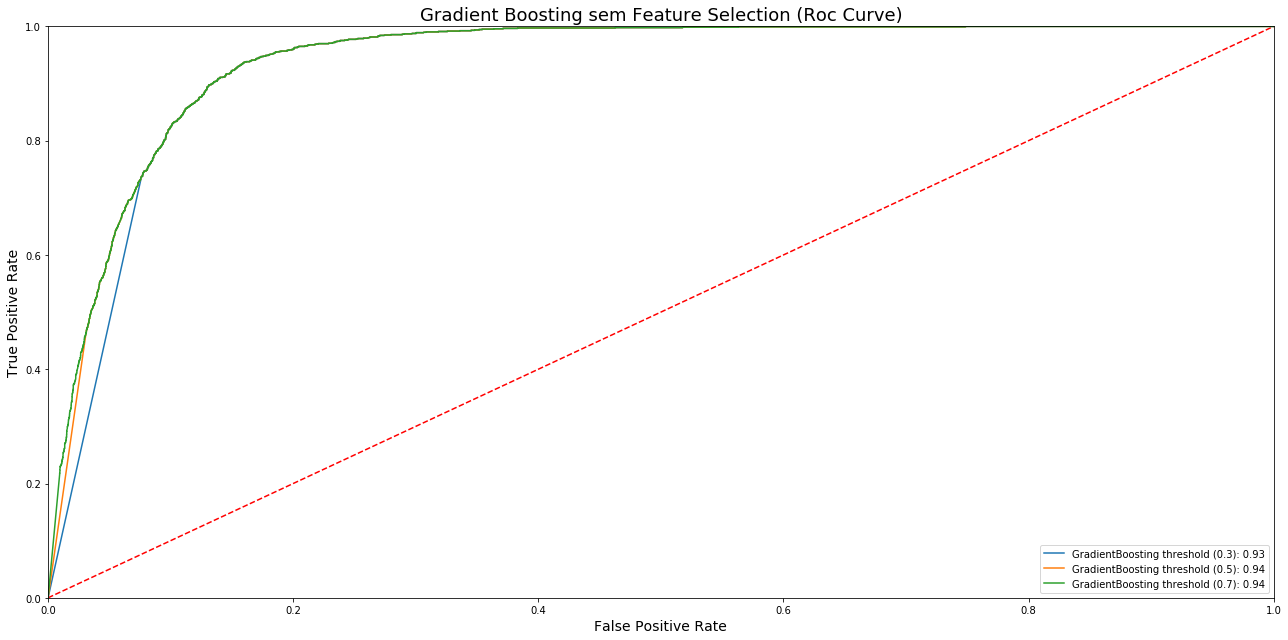

In [51]:
fpr_t03, tpr_t03, thresholds = roc_curve(y_test, y_prob_1_t03)
fpr_t05, tpr_t05, thresholds = roc_curve(y_test, y_prob_1_t05)
fpr_t07, tpr_t07, thresholds = roc_curve(y_test, y_prob_1_t07)

plt.figure(figsize=(18, 9))

xlim = [0, 1]
ylim = [0, 1]

plt.plot(xlim, ylim, '--r')

plt.plot(fpr_t03, tpr_t03, label='GradientBoosting threshold (0.3): %.2f' % roc_auc_score(y_test, y_prob_1_t03))
plt.plot(fpr_t05, tpr_t05, label='GradientBoosting threshold (0.5): %.2f' % roc_auc_score(y_test, y_prob_1_t05))
plt.plot(fpr_t07, tpr_t07, label='GradientBoosting threshold (0.7): %.2f' % roc_auc_score(y_test, y_prob_1_t07))

plt.title('Gradient Boosting sem Feature Selection (Roc Curve)', fontsize=18)

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

plt.legend(loc='lower right')

plt.tight_layout()

plt.show()

**Análise:**
- Os valores dos scores são bem parecidos, porém o modelo sem feature selection ainda possui um valor relativamente maior do que os outros.

## Salvar o modelo

In [55]:
save(clf_1, 'clf_1')

Objeto clf_1_2019-09-19_18-10-26.gz salvo com sucesso


### GridSearchCV

In [57]:
params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'max_depth': [2, 3, 4, 5]
}

grid_search = GridSearchCV(clf_1, param_grid=params, cv=5)

grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [58]:
save(grid_search, 'grid_search')

Objeto 'grid_search_2019-09-19_18-24-39.gz' salvo com sucesso
